# The Code for KNN to recommend movies to users

### Both item based and user based filtering have been applied

### Mounting up the drive to access the data from Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Setting up Spark Session

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

!java -version
!sudo update-alternatives --config java
!java -version


openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)
There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
* 2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)


In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

#Importing Libraries

In [0]:
from pyspark.sql import Row

In [0]:
import pandas as pd
import numpy as np
import math
import pickle
import os

In [0]:
RMSES=[]
RMSES1=[]

Coverage_Items=[]
Coverage_users=[]


#Function to calculate R-Squared

In [0]:
def r_squared(predictions,ratings):
    avg = np.mean(ratings)
    ss_res = 0
    for i in range(len(predictions)):
        err = (ratings[i]-predictions[i])**2
        ss_res += err
    ss_tot = 0
    for i in range(len(ratings)):
        ss_tot += (ratings[i]-avg)**2
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [0]:
R2_users=[]
R2_items=[]

#Sampling the Data -Ratings of the top 500 movies from users that have rated more than 1500 movies

In [0]:
ratingsData = spark.read.load("/content/drive/My Drive/ml-20m/ratings.csv",format="csv",header=True,inferSchema=True)
#ratingsData.show(5)

ratingsDataByCount = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 1000 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(500)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_2 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

pandasDf = ratingsData_2.toPandas()

#Splitting into training and test data according to the users (70% in training)

In [0]:
ratings = pandasDf
users =pd.DataFrame(ratings["userId"].unique())
users.columns=["userId"]

In [0]:
users_training = users.sample(frac=0.7)
users_testing = users.drop(users_training.index)

# Pivoting the data for user-user filtering

In [0]:
ratings_training = pd.merge(ratings, users_training, on=["userId"])
ratings_testing = pd.merge(ratings, users_testing, on=["userId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(index='userId', columns='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

movieId,1,2,3,5,6,7,10,11,16,17,19,21,22,25,31,32,34,36,39,44,47,48,50,52,58,62,70,95,104,105,110,111,112,141,145,150,151,153,158,160,...,6539,6711,6874,6934,7143,7147,7153,7361,7438,8360,8368,8636,8644,8665,8784,8874,8961,32587,33493,33794,35836,40815,44191,45722,46578,48394,48516,48780,49272,51662,54286,55820,56367,58559,59315,60069,68157,68954,72998,79132
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
741,5.0,3.0,3.0,4.0,3.5,4.5,4.0,0.0,4.0,4.5,0.5,3.5,2.5,4.5,5.0,5.0,1.0,0.0,0.5,0.0,5.0,2.0,5.0,0.0,5.0,0.0,4.0,0.5,0.5,4.5,4.5,5.0,0.5,3.0,0.0,5.0,4.0,4.0,0.5,0.5,...,4.5,4.5,4.0,0.0,3.5,4.5,5.0,5.0,3.5,5.0,0.0,3.0,0.0,3.5,0.0,0.0,4.5,4.5,3.5,4.5,0.0,0.0,4.5,0.0,5.0,0.0,5.0,5.0,4.5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768,0.0,3.0,0.0,2.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,4.0,0.0,0.0,5.0,0.0,0.0,3.0,2.0,5.0,0.0,4.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,4.0,3.5,0.0,0.0,3.0,3.0,4.0,3.5,0.0,0.0,...,4.5,3.5,3.5,3.5,4.0,0.0,5.0,0.0,3.5,3.5,3.5,1.5,3.5,3.5,0.0,4.5,0.0,4.0,4.0,4.0,0.0,3.5,4.0,4.0,0.0,3.5,3.5,3.5,4.0,4.0,3.5,3.5,0.0,3.5,3.5,0.0,3.0,0.0,3.0,4.0
775,4.5,2.0,3.5,1.0,3.5,3.0,4.5,4.0,4.0,4.0,1.5,2.5,3.0,4.0,2.0,4.0,4.0,3.5,3.5,3.0,4.5,2.5,4.0,2.5,3.5,2.5,4.0,1.0,4.0,3.5,5.0,5.0,3.5,4.5,0.0,4.0,2.5,3.5,1.5,1.5,...,4.0,1.0,5.0,3.0,0.0,0.0,4.0,5.0,5.0,0.0,3.0,5.0,3.5,0.0,0.0,4.5,5.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,4.0,4.0,2.0,3.0,4.0,3.0,1.0,3.0,3.0,3.0,1.0,4.0,2.0,4.0,0.0,4.0,4.0,2.0,3.0,2.0,4.0,1.0,5.0,4.0,0.0,2.0,4.0,2.0,4.0,2.0,4.0,4.0,1.0,3.0,3.0,4.0,3.0,1.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
982,3.0,2.0,2.0,2.5,3.5,2.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.5,3.0,3.5,2.5,3.0,3.0,1.5,5.0,2.5,4.0,3.0,0.0,0.0,3.5,2.5,3.0,3.0,3.0,4.0,3.0,3.5,3.0,3.0,3.0,3.0,2.5,2.5,...,3.5,4.0,4.0,2.0,3.5,3.5,4.0,3.5,4.0,3.0,3.0,2.0,3.0,3.0,0.0,4.0,3.5,4.0,3.0,3.5,4.0,3.5,3.5,3.5,0.0,4.0,3.5,3.0,3.5,3.5,3.5,4.5,0.0,3.5,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137037,4.0,3.0,2.0,3.0,5.0,2.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,4.0,2.0,3.0,2.5,4.0,2.0,1.0,5.0,0.0,5.0,3.0,0.0,5.0,3.5,3.0,4.0,1.0,5.0,5.0,2.0,4.0,4.0,4.0,3.0,2.0,1.0,1.0,...,3.0,4.0,5.0,4.0,5.0,4.0,4.5,5.0,5.0,4.5,2.5,3.5,0.0,2.5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137343,4.0,2.5,3.5,3.5,0.0,0.0,2.0,2.0,3.0,0.0,3.5,2.5,0.0,3.0,0.0,2.5,1.0,2.5,3.0,3.5,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,5.0,2.5,0.0,0.0,3.0,3.0,3.0,3.5,0.0,2.0,1.0,3.0,...,5.0,0.0,4.5,4.0,3.0,3.5,5.0,1.5,5.0,4.0,3.5,3.5,3.0,3.5,0.0,5.0,5.0,4.5,5.0,4.0,4.0,2.5,4.5,4.0,3.0,0.0,0.0,3.5,0.0,5.0,5.0,3.5,4.5,4.0,4.5,5.0,4.0,5.0,3.5,4.0
137686,5.0,3.0,3.0,0.0,4.0,3.0,4.0,4.0,4.0,0.0,3.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,3.0,3.0,5.0,3.0,5.0,0.0,4.0,4.0,4.0,3.0,3.0,0.0,4.5,5.0,4.0,3.5,3.0,4.0,3.0,3.0,3.0,1.0,...,4.0,4.0,4.5,3.5,3.5,4.0,5.0,4.5,4.0,4.0,4.0,4.0,3.5,4.0,4.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,4.5,4.0,4.0,4.5,4.5,4.0,4.0,4.0,4.0,4.5,0.0,4.5,0.0,4.5,0.0,0.0,0.0,0.0


## Converting the data into a sparse matrix

In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
from sklearn.neighbors import NearestNeighbors


In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


#Tuning the parameters for the KNN (user-user)

In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for user_id in users_testing["userId"]:
    neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
    predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for user_id in users_testing["userId"]:
      nonzero_ratings = []
      for movie_id in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
              nonzero_ratings.append(movie_id)

      squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                              predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


25 cosine 0.8951086010704897


#Plotting the graphs for different metrics of similarity

In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

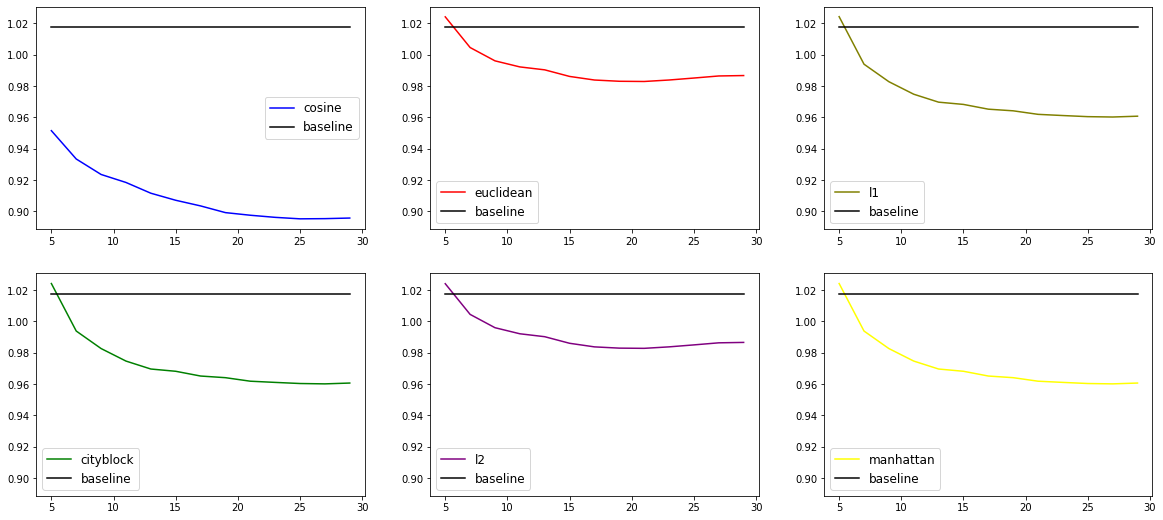

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

# Fitting the model according to best parameter

In [0]:
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=25, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
for user_id in users_testing["userId"]:
  neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
  #print(neighbors)
  predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 4. , 0. , ..., 5. , 3.5, 4.5],
       [0. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5. , 0. , 0. , ..., 3. , 0. , 4.5]])

In [0]:
predicted_ratings

array([[4.52, 4.4 , 4.24, ..., 3.92, 3.4 , 4.78],
       [3.52, 3.66, 2.3 , ..., 2.2 , 3.06, 1.92],
       [4.32, 3.76, 4.04, ..., 2.96, 2.88, 3.8 ],
       ...,
       [3.12, 4.4 , 3.02, ..., 3.8 , 3.3 , 4.72],
       [1.4 , 2.12, 0.62, ..., 3.56, 2.56, 4.78],
       [4.12, 3.76, 2.9 , ..., 4.28, 2.52, 4.72]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_users.append(np.average(r_squared(predicted_ratings,true_ratings)))

0.02377976980336697


#calculating RMSE

In [0]:
squared_error = 0.0
n = 0
for user_id in users_testing["userId"]:
    nonzero_ratings = []
    for movie_id in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
            nonzero_ratings.append(movie_id)

    squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                             predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

0.9333314950268173

In [0]:
RMSES.append(rmse)

#Splitting data according to movies (70% in training)

In [0]:
ratings = pandasDf
movies =pd.DataFrame(ratings["movieId"].unique())
movies.columns=["movieId"]


In [0]:
movies_training = movies.sample(frac=0.7)
movies_testing = movies.drop(movies_training.index)

#pivoting the data for item-item filtering

In [0]:
ratings_training = pd.merge(ratings, movies_training, on=["movieId"])
ratings_testing = pd.merge(ratings, movies_testing, on=["movieId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(columns='userId', index='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

userId,156,741,768,775,903,982,1849,2261,2397,3284,3289,3318,3397,3664,3797,3858,3907,4222,4276,4358,4450,4507,4967,5843,6099,6373,6636,6719,7201,7699,7828,8405,8647,8805,8963,9034,9087,9544,9545,9562,...,129540,129583,130191,130459,130477,130622,130767,130987,131275,131347,131651,131894,131904,131961,133133,133372,133811,134401,134497,134567,134637,134690,134773,135033,135090,135155,135425,135795,136054,136268,136599,136875,137037,137202,137277,137343,137686,137885,138208,138325
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.0,3.0,0.0,3.5,2.0,2.0,2.5,2.5,4.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0,1.0,0.0,0.0,2.5,3.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,2.5,4.0,0.0,0.0,0.0,4.0,2.0,4.0,3.0,...,2.0,3.5,4.5,3.0,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,1.0,0.0,2.0,3.5,0.0,0.0,4.5,0.0,0.0,3.0,2.0,2.0,0.0,0.0,1.5,3.0,2.0,0.0,0.0,2.0,3.5,3.0,3.5,3.0,4.0,2.0,0.0
6,4.0,3.5,4.0,3.5,4.0,3.5,0.0,3.5,4.0,0.0,0.0,3.0,0.0,2.5,4.0,3.0,4.0,0.0,1.5,5.0,0.0,4.0,0.0,3.5,4.5,3.0,4.0,5.0,2.0,4.5,3.0,4.0,2.0,3.0,3.5,2.0,3.0,4.0,4.0,4.0,...,5.0,0.0,3.5,3.5,5.0,5.0,4.0,3.0,4.0,4.5,3.0,0.0,3.5,4.5,4.0,3.0,5.0,3.5,0.0,3.5,2.0,1.5,3.0,4.0,3.5,4.0,3.5,4.0,4.0,5.0,3.5,4.0,5.0,3.0,4.0,0.0,4.0,5.0,3.0,4.5
7,4.0,4.5,0.0,3.0,3.0,2.0,4.0,1.5,3.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,1.5,2.5,3.0,2.5,3.0,0.0,0.0,2.0,2.0,3.0,...,0.0,0.0,3.5,3.5,0.0,2.5,0.0,4.5,0.0,3.5,0.0,0.0,0.0,0.0,1.5,2.5,5.0,0.0,0.0,3.5,0.0,0.0,2.0,1.0,0.5,0.0,0.0,1.5,3.0,3.0,3.5,0.0,2.0,3.0,3.0,0.0,3.0,0.0,3.0,0.0
10,4.0,4.0,4.0,4.5,1.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,0.0,4.0,0.0,1.5,4.0,3.0,2.0,5.0,0.0,3.0,4.0,4.0,2.0,3.0,0.0,0.0,3.0,4.0,3.0,2.5,4.0,3.0,3.0,0.0,3.0,2.0,0.0,4.5,...,3.0,3.5,4.0,3.0,4.0,1.5,0.0,2.5,4.0,4.0,0.0,0.0,3.5,3.0,3.5,0.0,5.0,1.0,3.0,3.5,2.5,0.0,3.0,0.0,2.5,4.0,3.0,3.0,3.0,3.0,3.5,3.0,4.0,4.0,3.0,2.0,4.0,3.0,2.0,3.5
11,5.0,0.0,0.0,4.0,3.0,3.0,4.0,4.5,3.0,4.0,4.0,3.0,3.0,2.0,1.0,1.5,3.5,0.0,0.0,4.0,2.0,3.0,2.5,4.0,0.0,0.0,0.0,3.0,0.0,0.0,1.5,4.0,0.0,3.0,3.0,0.0,4.0,3.0,4.0,0.0,...,4.0,4.5,3.5,3.0,0.0,0.0,0.0,3.5,4.0,3.0,0.0,0.0,3.0,0.0,2.5,4.0,5.0,0.0,0.0,3.5,0.5,0.0,4.0,2.0,2.5,4.0,2.0,0.0,2.5,4.0,3.5,0.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59315,0.0,0.0,3.5,0.0,0.0,3.0,4.0,0.0,4.0,3.0,4.5,0.0,3.0,5.0,2.5,3.0,3.5,4.5,0.0,5.0,3.0,0.0,4.0,0.0,3.5,0.0,0.0,4.0,3.5,0.0,0.0,4.0,0.0,0.0,2.5,3.5,4.0,3.5,0.0,5.0,...,0.0,4.0,0.0,3.0,2.5,3.0,3.0,3.0,4.5,4.0,3.5,5.0,3.5,4.0,0.0,0.0,4.0,0.0,5.0,4.0,3.5,0.0,4.0,0.0,3.5,4.0,0.0,3.5,3.5,3.5,3.5,5.0,0.0,3.5,3.5,4.5,0.0,0.0,3.5,4.0
60069,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,4.0,0.0,4.5,4.0,3.0,5.0,4.0,5.0,3.0,5.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0,4.0,0.0,0.0,3.5,...,0.0,4.0,0.0,0.0,0.0,0.0,4.0,3.5,4.5,4.5,0.0,5.0,3.5,4.5,0.0,0.0,0.0,0.0,5.0,3.5,0.0,4.0,4.5,0.0,1.5,0.0,4.5,3.5,4.0,3.0,4.0,0.0,0.0,4.5,4.5,5.0,4.5,0.0,4.0,5.0
68157,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,3.5,4.0,5.0,0.0,5.0,0.0,0.0,3.5,0.0,4.0,0.0,0.0,5.0,4.5,0.0,0.0,4.0,0.0,0.0,3.0,4.5,3.5,3.5,0.0,5.0,...,0.0,5.0,0.0,3.5,5.0,4.0,4.5,3.5,5.0,5.0,4.5,0.0,2.5,0.0,0.0,0.0,4.5,0.0,0.0,3.5,2.5,3.0,5.0,0.0,4.0,0.0,0.0,0.0,2.5,3.0,4.0,4.5,0.0,4.0,4.5,4.0,0.0,0.0,4.5,4.0


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


#Tuning the parameters for the KNN (item-item)

In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for movieId in movies_testing["movieId"]:
    neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
    predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for movieId in movies_testing["movieId"]:
      nonzero_ratings = []
      for userId in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
              nonzero_ratings.append(userId)

      squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                              predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


27 cosine 0.9220620483696736


#Plotting the graphs for different metrics of similarity

In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

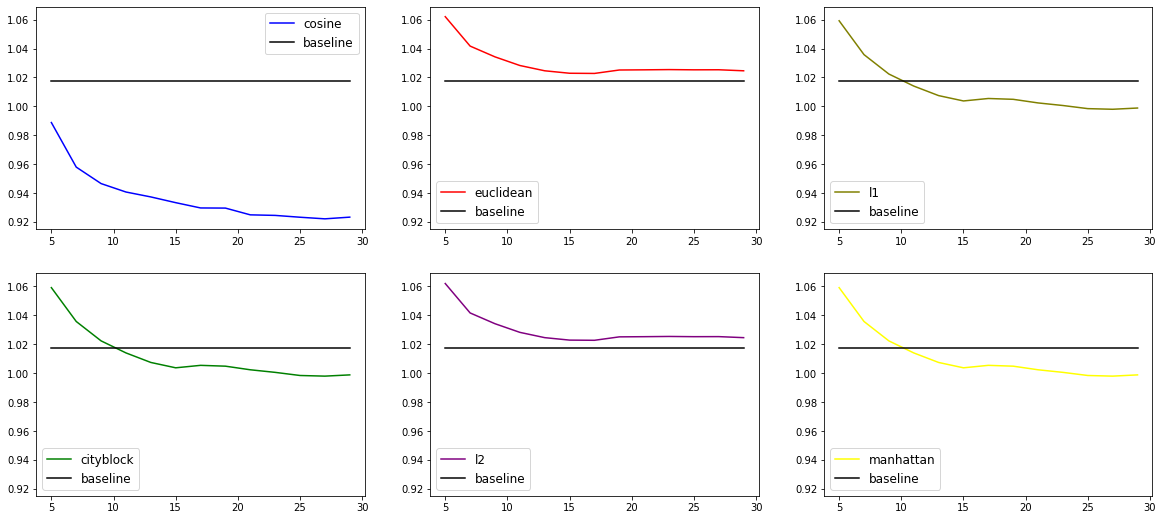

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

#Fitting the model according to best parameters

In [0]:
from sklearn.neighbors import NearestNeighbors
#auto', 'ball_tree', 'kd_tree', 'brute'
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=27, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies_testing["movieId"]:
  neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
  predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 3. , ..., 0. , 0. , 0. ]])

In [0]:
predicted_ratings

array([[4.55555556, 4.42592593, 4.25925926, ..., 3.77777778, 3.48148148,
        4.75925926],
       [3.55555556, 3.59259259, 2.2962963 , ..., 2.40740741, 3.05555556,
        2.11111111],
       [4.37037037, 3.77777778, 3.88888889, ..., 3.07407407, 2.85185185,
        3.87037037],
       ...,
       [0.        , 0.        , 2.25925926, ..., 0.        , 2.22222222,
        2.98148148],
       [0.        , 0.        , 2.85185185, ..., 0.        , 2.05555556,
        2.31481481],
       [0.        , 0.        , 2.5       , ..., 0.        , 2.05555556,
        2.94444444]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_items.append(np.average(r_squared(predicted_ratings,true_ratings)))

-0.03981622744234246


#Calculating RMSE

In [0]:
squared_error = 0.0
n = 0
for movieId in movies_testing["movieId"]:
    nonzero_ratings = []
    for userId in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
            nonzero_ratings.append(userId)

    squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                             predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

0.9578912497443468

In [0]:
RMSES1.append(rmse)

#Predicting for calculating the Coverage

In [0]:
matrix  = ratings.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
matrix_sparse = csr_matrix(matrix.values)


In [0]:
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=27, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(matrix_sparse,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies["movieId"]:
  neighbors = neighbor_indices[list(movies["movieId"]).index(movieId)]
  predicted_ratings[list(movies["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))
for movieId in movies["movieId"]:
  true_ratings[list(movies["movieId"]).index(movieId), :] = matrix.values[list(movies["movieId"]).index(movieId)]


In [0]:
predicted_ratings

array([[4.07407407, 4.2962963 , 3.62962963, ..., 3.        , 3.38888889,
        4.59259259],
       [4.44444444, 3.46296296, 3.64814815, ..., 3.03703704, 3.        ,
        3.75925926],
       [3.62962963, 3.35185185, 2.96296296, ..., 3.11111111, 2.75925926,
        2.46296296],
       ...,
       [0.51851852, 2.7962963 , 2.75925926, ..., 0.18518519, 3.51851852,
        4.2037037 ],
       [1.22222222, 2.46296296, 3.27777778, ..., 0.55555556, 3.53703704,
        4.27777778],
       [1.25925926, 2.66666667, 3.40740741, ..., 0.44444444, 3.64814815,
        4.33333333]])

In [0]:
recommendations = pd.DataFrame(data=predicted_ratings)

In [0]:
recommendations1 = recommendations.transpose()

In [0]:
recommendations1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,4.074074,4.444444,3.629630,3.851852,4.407407,3.740741,4.518519,4.185185,4.148148,3.518519,3.611111,3.555556,4.592593,4.074074,4.185185,4.222222,3.925926,3.629630,3.444444,3.129630,4.148148,3.148148,4.148148,3.000000,3.555556,4.259259,4.185185,4.444444,3.777778,4.000000,4.481481,3.962963,4.148148,3.962963,4.148148,4.111111,3.962963,4.407407,3.851852,4.037037,...,3.666667,3.111111,3.370370,3.000000,3.259259,3.000000,3.555556,2.777778,3.185185,2.555556,2.407407,3.185185,2.925926,3.185185,2.259259,3.037037,2.962963,3.185185,2.740741,3.407407,1.629630,1.518519,1.925926,1.333333,1.074074,0.740741,1.814815,1.074074,1.777778,0.666667,0.703704,1.037037,0.851852,0.851852,0.518519,0.851852,0.888889,0.518519,1.222222,1.259259
1,4.296296,3.462963,3.351852,3.259259,4.259259,3.777778,3.629630,3.851852,4.351852,4.222222,2.870370,4.351852,3.722222,4.314815,4.018519,4.444444,3.796296,4.351852,4.074074,2.425926,4.351852,3.166667,4.351852,4.333333,4.351852,3.814815,4.148148,3.037037,3.259259,4.166667,4.055556,4.574074,3.666667,4.537037,3.092593,3.981481,4.129630,3.703704,3.277778,2.796296,...,4.074074,4.425926,4.333333,3.148148,3.981481,4.388889,3.925926,4.537037,4.111111,3.555556,3.370370,3.962963,3.518519,4.074074,3.629630,3.814815,4.333333,4.333333,3.425926,4.203704,3.740741,3.018519,3.648148,2.925926,3.055556,3.018519,3.555556,2.814815,3.370370,2.129630,2.166667,2.796296,2.629630,2.537037,2.185185,2.611111,2.518519,2.796296,2.462963,2.666667
2,3.629630,3.648148,2.962963,2.574074,4.148148,2.222222,4.000000,2.962963,4.074074,1.703704,3.333333,3.777778,3.611111,2.962963,2.981481,4.240741,3.481481,2.777778,3.666667,3.481481,4.259259,2.166667,4.092593,2.351852,1.388889,2.666667,4.314815,3.648148,3.370370,2.666667,3.870370,3.629630,3.796296,3.500000,3.629630,3.555556,3.648148,4.055556,2.833333,3.296296,...,3.962963,3.518519,4.111111,3.870370,3.833333,3.740741,4.074074,3.574074,4.111111,3.166667,3.592593,4.018519,4.000000,3.981481,2.444444,4.037037,3.814815,4.055556,3.907407,4.074074,3.388889,3.500000,3.629630,3.666667,2.796296,3.148148,3.425926,3.240741,3.740741,3.611111,3.129630,3.240741,2.833333,3.092593,3.166667,3.129630,3.037037,2.759259,3.277778,3.407407
3,4.388889,3.981481,3.574074,3.555556,4.444444,3.611111,4.111111,3.925926,4.425926,4.185185,3.629630,4.296296,3.759259,4.333333,3.777778,4.555556,4.407407,4.240741,4.333333,3.500000,4.481481,3.666667,4.500000,4.444444,4.000000,3.759259,4.462963,3.351852,4.203704,3.925926,4.314815,4.629630,3.981481,4.185185,3.444444,4.314815,4.092593,4.055556,3.574074,3.425926,...,3.851852,3.944444,4.074074,3.462963,3.370370,3.851852,4.000000,3.944444,3.888889,3.351852,3.277778,3.851852,3.333333,3.685185,3.000000,4.333333,3.703704,3.777778,3.333333,3.925926,2.555556,1.759259,2.425926,1.629630,1.296296,1.592593,2.129630,1.203704,2.111111,1.351852,0.685185,1.222222,0.722222,1.222222,0.685185,1.203704,1.018519,1.018519,1.203704,1.314815
4,3.666667,3.666667,3.444444,3.555556,3.888889,3.666667,3.259259,3.629630,4.111111,3.407407,3.185185,4.037037,3.703704,3.851852,3.555556,3.703704,3.851852,3.962963,4.148148,2.888889,4.000000,3.185185,4.037037,4.148148,3.222222,3.518519,3.925926,3.296296,3.814815,3.259259,3.740741,4.111111,3.592593,4.074074,2.925926,3.777778,3.666667,3.481481,3.222222,3.370370,...,2.444444,2.296296,2.777778,1.518519,1.888889,2.444444,2.666667,2.074074,2.444444,1.518519,1.259259,2.185185,1.851852,2.111111,1.444444,2.370370,2.111111,2.444444,1.592593,2.407407,1.259259,0.296296,1.074074,0.407407,0.666667,0.333333,1.296296,0.592593,0.962963,0.259259,0.259259,0.777778,0.481481,0.481481,0.259259,0.333333,0.629630,0.481481,0.555556,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

#Calculating Coverage

In [0]:
l = []
temp_list=[]
for i in recommendations1.index:
  for j in recommendations1.columns:
    temp= (movies["movieId"][j],recommendations1.loc[i][j])
    temp_list.append(temp)
  l.append(temp_list)
  temp_list=[]

In [0]:
finallist=[]
for list1 in l:
  finallist.append(sorted(list1, key=lambda x: x[1], reverse=True))

In [0]:
d={"userId":users["userId"], "recommendations":finallist}
rec_movies_1=pd.DataFrame(d)

In [0]:
from operator import itemgetter
from itertools import groupby
import pandas as pd
list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

In [0]:
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

In [0]:
l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

In [0]:
Coverage = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies = " + str(Coverage) )

Coverage of movies = 0.886


In [0]:
Coverage_Items.append(Coverage)

In [0]:
list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 
Coverage = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users = " + str(Coverage))

Coverage based on users = 0.8549222797927462


In [0]:
Coverage_users.append(Coverage)

#Sampling the Data -Ratings of the top 1000 movies from users that have rated more than 1500 movies and repaeting the things done previously

In [0]:
ratingsData = spark.read.load("/content/drive/My Drive/ml-20m/ratings.csv",format="csv",header=True,inferSchema=True)
#ratingsData.show(5)

ratingsDataByCount = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 1000 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(1000)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_2 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

pandasDf = ratingsData_2.toPandas()

In [0]:
ratings = pandasDf
users =pd.DataFrame(ratings["userId"].unique())
users.columns=["userId"]

In [0]:
users_training = users.sample(frac=0.7)
users_testing = users.drop(users_training.index)

In [0]:
ratings_training = pd.merge(ratings, users_training, on=["userId"])
ratings_testing = pd.merge(ratings, users_testing, on=["userId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(index='userId', columns='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

movieId,1,2,3,5,6,7,10,11,14,16,17,18,19,21,22,24,25,29,31,32,34,36,39,44,45,47,48,50,52,58,60,62,70,79,95,104,105,107,110,111,...,48774,48780,49272,49530,50872,51255,51662,52973,53125,53996,54001,54272,54286,54503,55765,55820,56174,56367,56782,58559,59315,60069,60684,63082,64614,68157,68358,68954,69122,69757,70286,71535,72998,73017,74458,78499,79132,80463,81591,81845
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,2.0,3.0,4.0,4.0,4.0,5.0,0.0,4.0,4.0,3.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0,5.0,3.0,3.5,0.0,0.0,2.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,4.0,3.0,4.0,2.0,4.0,0.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,5.0,3.0,3.0,4.0,3.5,4.5,4.0,0.0,4.5,4.0,4.5,0.0,0.5,3.5,2.5,0.0,4.5,0.0,5.0,5.0,1.0,0.0,0.5,0.0,0.0,5.0,2.0,5.0,0.0,5.0,0.0,0.0,4.0,0.0,0.5,0.5,4.5,0.0,4.5,5.0,...,4.5,5.0,4.5,4.5,1.5,0.0,0.0,0.0,0.0,0.5,0.0,0.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768,0.0,3.0,0.0,2.0,4.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,2.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,4.0,3.5,...,3.5,3.5,4.0,3.5,0.0,2.5,4.0,0.0,4.0,3.5,3.5,3.0,3.5,3.0,3.5,3.5,3.5,0.0,0.0,3.5,3.5,0.0,3.5,3.5,4.0,3.0,4.0,0.0,3.0,0.0,3.0,4.0,3.0,3.5,3.0,0.0,4.0,0.0,4.0,0.0
903,4.0,4.0,2.0,3.0,4.0,3.0,1.0,3.0,3.0,3.0,3.0,2.0,1.0,4.0,2.0,2.0,4.0,4.0,0.0,4.0,4.0,2.0,3.0,2.0,4.0,4.0,1.0,5.0,4.0,0.0,4.0,2.0,4.0,1.0,2.0,4.0,2.0,2.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1849,4.5,3.0,2.5,3.0,0.0,4.0,4.0,4.0,0.0,0.0,4.0,0.0,2.0,3.0,3.5,3.0,0.0,0.0,3.0,3.5,3.5,0.0,3.5,0.0,3.5,4.0,3.0,5.0,3.0,0.0,0.0,3.0,3.5,0.0,3.0,2.5,0.0,0.0,4.5,4.0,...,3.5,3.5,4.0,0.0,0.0,3.5,3.5,0.0,3.0,0.0,3.5,3.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137277,4.0,2.5,3.0,3.0,4.0,3.0,3.0,3.0,0.0,3.5,0.0,3.0,2.5,0.0,3.0,0.0,3.5,4.0,0.0,4.5,4.0,0.0,0.0,1.5,0.0,4.5,0.0,4.5,0.0,4.0,0.0,0.0,3.5,0.0,2.0,3.0,3.5,0.0,3.5,4.0,...,5.0,4.0,3.5,3.5,4.0,4.0,3.0,3.5,2.5,2.5,3.0,3.0,4.0,3.5,0.0,4.0,3.0,4.0,0.0,4.0,3.5,4.5,4.0,4.0,4.0,4.5,3.5,4.0,2.5,3.5,4.5,3.5,3.5,3.5,4.0,5.0,4.0,4.0,4.0,3.5
137343,4.0,2.5,3.5,3.5,0.0,0.0,2.0,2.0,0.0,3.0,0.0,1.0,3.5,2.5,0.0,3.0,3.0,0.0,0.0,2.5,1.0,2.5,3.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,2.0,5.0,2.5,0.0,0.0,0.0,...,0.0,3.5,0.0,0.0,4.0,2.5,5.0,3.5,3.5,4.0,0.0,3.5,5.0,4.5,0.0,3.5,3.5,4.5,0.0,4.0,4.5,5.0,3.5,0.0,3.5,4.0,4.0,5.0,5.0,0.0,4.0,4.5,3.5,0.0,3.0,5.0,4.0,3.0,2.5,0.0
137885,5.0,3.0,4.0,3.0,5.0,0.0,3.0,3.0,0.0,4.0,3.0,1.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,5.0,5.0,4.0,4.0,2.0,2.0,4.0,3.0,5.0,0.0,0.0,4.0,0.0,2.0,2.0,3.0,3.0,0.0,3.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for user_id in users_testing["userId"]:
    neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
    predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for user_id in users_testing["userId"]:
      nonzero_ratings = []
      for movie_id in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
              nonzero_ratings.append(movie_id)

      squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                              predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


13 cosine 0.9832783391046737


In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

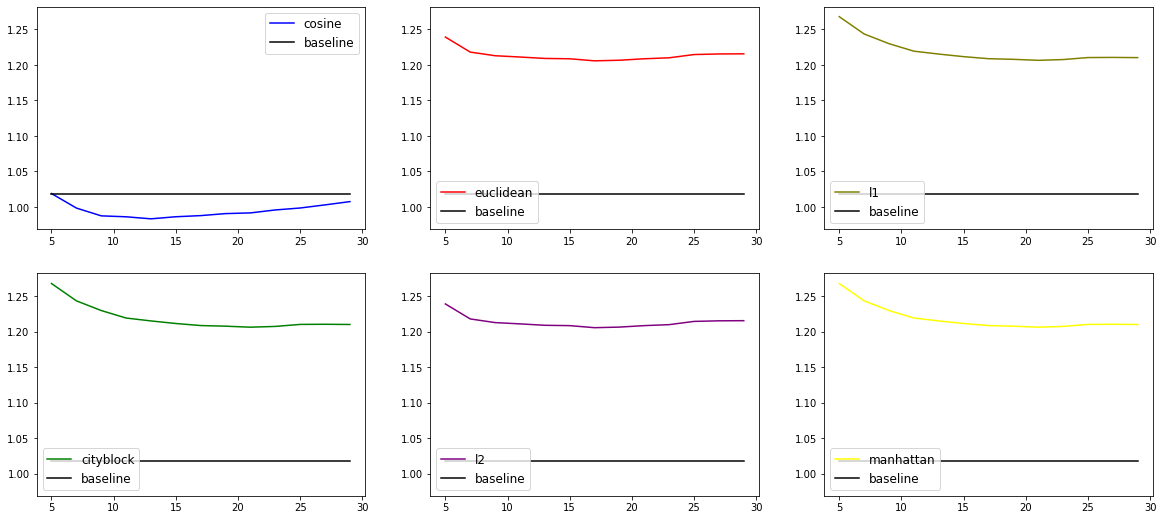

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

In [0]:
from sklearn.neighbors import NearestNeighbors
#auto', 'ball_tree', 'kd_tree', 'brute'
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
for user_id in users_testing["userId"]:
  neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
  #print(neighbors)
  predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 4. , 0. , ..., 5. , 3.5, 4.5],
       [0. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5. , 0. , 0. , ..., 3. , 0. , 4.5]])

In [0]:
predicted_ratings

array([[4.46153846, 4.76923077, 4.38461538, ..., 3.92307692, 3.53846154,
        4.84615385],
       [3.23076923, 4.15384615, 2.69230769, ..., 2.07692308, 3.30769231,
        2.42307692],
       [4.23076923, 3.88461538, 4.11538462, ..., 3.30769231, 2.61538462,
        3.84615385],
       ...,
       [2.46153846, 4.53846154, 2.92307692, ..., 4.30769231, 3.23076923,
        4.76923077],
       [0.46153846, 0.65384615, 0.        , ..., 3.        , 2.        ,
        4.80769231],
       [4.53846154, 3.15384615, 2.61538462, ..., 4.15384615, 2.84615385,
        4.76923077]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_users.append(np.average(r_squared(predicted_ratings,true_ratings)))

0.08116695510175895


In [0]:
squared_error = 0.0
n = 0
for user_id in users_testing["userId"]:
    nonzero_ratings = []
    for movie_id in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
            nonzero_ratings.append(movie_id)

    squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                             predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

0.9832783391046737

In [0]:
RMSES.append(rmse)

In [0]:
ratings = pandasDf
movies =pd.DataFrame(ratings["movieId"].unique())
movies.columns=["movieId"]


In [0]:
movies_training = movies.sample(frac=0.7)
movies_testing = movies.drop(movies_training.index)

In [0]:
ratings_training = pd.merge(ratings, movies_training, on=["movieId"])
ratings_testing = pd.merge(ratings, movies_testing, on=["movieId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(columns='userId', index='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

userId,156,741,768,775,903,982,1849,2261,2397,3284,3289,3318,3397,3664,3797,3858,3907,4222,4276,4358,4450,4507,4967,5843,6099,6373,6636,6719,7201,7699,7828,8405,8647,8805,8963,9034,9087,9544,9545,9562,...,129540,129583,130191,130459,130477,130622,130767,130987,131275,131347,131651,131894,131904,131961,133133,133372,133811,134401,134497,134567,134637,134690,134773,135033,135090,135155,135425,135795,136054,136268,136599,136875,137037,137202,137277,137343,137686,137885,138208,138325
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,0.0,4.5,4.0,3.0,4.5,3.0,4.0,5.0,5.0,4.5,3.5,5.0,0.0,4.0,4.0,5.0,0.0,5.0,3.0,4.0,4.0,5.0,4.0,2.5,4.0,4.0,4.5,5.0,2.5,5.0,3.0,3.0,2.5,0.0,5.0,3.0,3.0,5.0,...,5.0,4.5,5.0,0.0,3.0,3.0,4.5,4.0,5.0,5.0,2.0,5.0,3.0,4.0,2.5,5.0,5.0,0.0,5.0,4.0,3.0,4.5,5.0,0.0,2.5,5.0,3.0,3.5,3.5,4.0,4.0,4.0,4.0,4.5,4.0,4.0,5.0,5.0,3.0,5.0
2,5.0,3.0,3.0,2.0,4.0,2.0,3.0,3.5,4.0,3.0,0.0,3.0,2.0,4.5,2.0,1.5,2.5,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0,2.5,0.0,4.0,1.0,2.0,2.5,3.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,...,3.0,3.5,3.5,3.5,0.5,3.0,0.0,3.0,3.5,2.5,0.0,5.0,3.0,2.0,2.5,3.0,5.0,2.5,4.0,4.0,0.0,2.0,0.0,0.0,2.5,0.0,0.0,4.0,0.0,2.0,2.0,3.0,3.0,2.5,2.5,2.5,3.0,3.0,2.0,3.0
6,4.0,3.5,4.0,3.5,4.0,3.5,0.0,3.5,4.0,0.0,0.0,3.0,0.0,2.5,4.0,3.0,4.0,0.0,1.5,5.0,0.0,4.0,0.0,3.5,4.5,3.0,4.0,5.0,2.0,4.5,3.0,4.0,2.0,3.0,3.5,2.0,3.0,4.0,4.0,4.0,...,5.0,0.0,3.5,3.5,5.0,5.0,4.0,3.0,4.0,4.5,3.0,0.0,3.5,4.5,4.0,3.0,5.0,3.5,0.0,3.5,2.0,1.5,3.0,4.0,3.5,4.0,3.5,4.0,4.0,5.0,3.5,4.0,5.0,3.0,4.0,0.0,4.0,5.0,3.0,4.5
10,4.0,4.0,4.0,4.5,1.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,0.0,4.0,0.0,1.5,4.0,3.0,2.0,5.0,0.0,3.0,4.0,4.0,2.0,3.0,0.0,0.0,3.0,4.0,3.0,2.5,4.0,3.0,3.0,0.0,3.0,2.0,0.0,4.5,...,3.0,3.5,4.0,3.0,4.0,1.5,0.0,2.5,4.0,4.0,0.0,0.0,3.5,3.0,3.5,0.0,5.0,1.0,3.0,3.5,2.5,0.0,3.0,0.0,2.5,4.0,3.0,3.0,3.0,3.0,3.5,3.0,4.0,4.0,3.0,2.0,4.0,3.0,2.0,3.5
11,5.0,0.0,0.0,4.0,3.0,3.0,4.0,4.5,3.0,4.0,4.0,3.0,3.0,2.0,1.0,1.5,3.5,0.0,0.0,4.0,2.0,3.0,2.5,4.0,0.0,0.0,0.0,3.0,0.0,0.0,1.5,4.0,0.0,3.0,3.0,0.0,4.0,3.0,4.0,0.0,...,4.0,4.5,3.5,3.0,0.0,0.0,0.0,3.5,4.0,3.0,0.0,0.0,3.0,0.0,2.5,4.0,5.0,0.0,0.0,3.5,0.5,0.0,4.0,2.0,2.5,4.0,2.0,0.0,2.5,4.0,3.5,0.0,3.0,3.0,3.0,2.0,4.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,5.0,0.0,3.0,0.0,3.0,2.0,4.0,4.5,0.0,0.0,3.5,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,2.5,0.0,3.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,3.5,4.0,5.0,5.0,0.0,0.0,3.5,0.0,0.0,0.0,5.0,0.0,5.0,3.5,0.0,3.5,4.5,0.0,1.5,0.0,0.0,0.0,4.5,3.5,4.5,0.0,0.0,4.5,5.0,5.0,0.0,0.0,4.0,5.0
79132,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,4.5,4.0,0.0,4.0,0.0,3.5,3.5,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,2.0,2.0,0.0,3.0,0.0,0.0,...,0.0,5.0,0.0,3.5,4.0,4.0,3.5,4.5,5.0,5.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,2.5,3.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,3.5,4.5,4.5,0.0,4.0,4.0,4.0,0.0,0.0,3.0,4.5
80463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,3.5,0.0,4.0,4.0,4.5,4.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,...,0.0,4.5,0.0,0.0,1.0,3.5,4.0,4.5,5.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,4.5,4.0,4.0,4.5,3.5,0.0,5.0,0.0,3.0,0.0,0.0,0.0,4.0,3.5,3.5,4.0,0.0,4.5,4.0,3.0,0.0,0.0,4.5,4.5


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for movieId in movies_testing["movieId"]:
    neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
    predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for movieId in movies_testing["movieId"]:
      nonzero_ratings = []
      for userId in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
              nonzero_ratings.append(userId)

      squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                              predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


29 cosine 0.891308178736484


In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

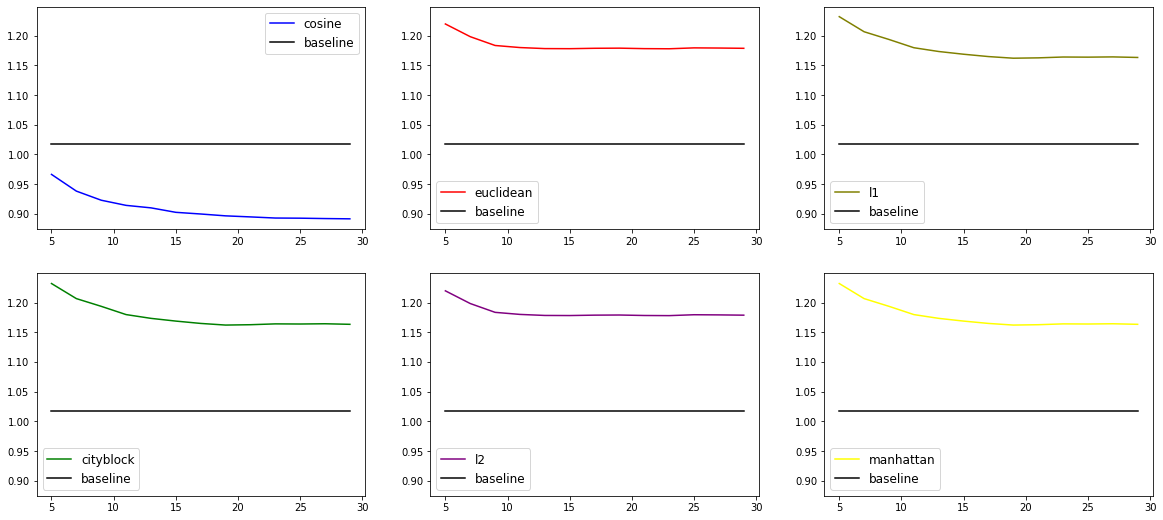

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

In [0]:
from sklearn.neighbors import NearestNeighbors
#auto', 'ball_tree', 'kd_tree', 'brute'
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=29, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies_testing["movieId"]:
  neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
  predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 3. , ..., 0. , 0. , 0. ]])

In [0]:
predicted_ratings

array([[4.55172414, 4.44827586, 4.22413793, ..., 3.79310345, 3.51724138,
        4.74137931],
       [3.62068966, 3.67241379, 2.4137931 , ..., 2.51724138, 3.05172414,
        2.12068966],
       [4.37931034, 3.70689655, 3.89655172, ..., 3.03448276, 2.82758621,
        3.87931034],
       ...,
       [0.        , 0.        , 2.36206897, ..., 0.        , 2.18965517,
        2.9137931 ],
       [0.        , 0.        , 2.89655172, ..., 0.        , 2.10344828,
        2.29310345],
       [0.        , 0.        , 2.53448276, ..., 0.        , 2.17241379,
        3.05172414]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_items.append(np.average(r_squared(predicted_ratings,true_ratings)))

-0.0451591127139207


In [0]:
squared_error = 0.0
n = 0
for movieId in movies_testing["movieId"]:
    nonzero_ratings = []
    for userId in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
            nonzero_ratings.append(userId)

    squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                             predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

0.891308178736484

In [0]:
RMSES1.append(rmse)

In [0]:
matrix  = ratings.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
matrix_sparse = csr_matrix(matrix.values)


In [0]:
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=29, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(matrix_sparse,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies["movieId"]:
  neighbors = neighbor_indices[list(movies["movieId"]).index(movieId)]
  predicted_ratings[list(movies["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))
for movieId in movies["movieId"]:
  true_ratings[list(movies["movieId"]).index(movieId), :] = matrix.values[list(movies["movieId"]).index(movieId)]


In [0]:
predicted_ratings

array([[4.24137931, 4.37931034, 3.18965517, ..., 3.        , 3.32758621,
        4.56896552],
       [4.17241379, 3.4137931 , 3.27586207, ..., 2.86206897, 2.89655172,
        3.46551724],
       [3.62068966, 3.12068966, 2.79310345, ..., 3.06896552, 2.67241379,
        2.37931034],
       ...,
       [0.        , 1.34482759, 2.37931034, ..., 0.        , 3.63793103,
        3.96551724],
       [0.        , 1.32758621, 2.37931034, ..., 0.        , 3.51724138,
        3.82758621],
       [0.        , 1.32758621, 2.10344828, ..., 0.        , 3.65517241,
        3.98275862]])

In [0]:
recommendations = pd.DataFrame(data=predicted_ratings)

In [0]:
recommendations1 = recommendations.transpose()

In [0]:
recommendations1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,4.241379,4.172414,3.620690,3.827586,4.310345,3.448276,4.482759,4.137931,2.965517,4.103448,3.827586,2.551724,3.706897,3.620690,4.551724,3.931034,3.931034,3.103448,4.103448,4.448276,4.137931,3.810345,3.551724,3.155172,3.344828,4.448276,3.172414,4.379310,3.034483,3.965517,3.758621,4.172414,4.000000,4.068966,4.344828,3.689655,3.793103,3.620690,4.586207,3.758621,...,1.137931,0.827586,1.344828,0.482759,0.310345,0.000000,0.172414,0.000000,0.000000,0.310345,0.137931,0.172414,0.655172,0.000000,0.310345,0.931034,0.000000,0.000000,0.310345,0.000000,0.172414,0.310345,0.000000,0.000000,0.000000,0.000000,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.379310,3.413793,3.120690,2.931034,4.551724,3.637931,3.741379,3.689655,4.068966,4.620690,4.155172,4.086207,3.137931,4.327586,3.724138,2.172414,4.482759,3.327586,3.396552,4.413793,3.706897,4.362069,3.758621,2.413793,3.689655,4.465517,2.862069,4.551724,4.206897,4.224138,3.068966,3.465517,3.982759,2.000000,3.068966,2.913793,4.086207,2.568966,4.275862,4.689655,...,3.500000,3.206897,3.586207,2.948276,2.344828,2.637931,2.258621,1.896552,2.034483,2.206897,2.017241,2.362069,2.224138,1.482759,2.206897,2.775862,1.568966,2.000000,2.448276,2.293103,2.051724,2.086207,1.482759,1.327586,1.344828,1.310345,1.413793,1.620690,1.172414,1.172414,1.448276,1.327586,1.293103,1.293103,1.172414,1.465517,1.327586,1.344828,1.327586,1.327586
2,3.189655,3.275862,2.793103,2.241379,4.172414,2.000000,3.793103,2.862069,1.965517,4.241379,1.258621,3.793103,3.344828,3.672414,3.603448,2.586207,3.379310,2.948276,2.655172,4.034483,2.948276,2.862069,3.310345,3.568966,2.448276,4.120690,1.810345,4.051724,1.810345,1.586207,1.982759,2.258621,4.189655,2.517241,3.741379,3.000000,2.344828,1.896552,3.620690,3.775862,...,3.017241,2.896552,3.568966,2.862069,2.206897,2.517241,3.413793,2.396552,3.379310,3.224138,3.224138,2.827586,3.068966,2.620690,2.844828,3.224138,3.017241,2.206897,2.724138,2.879310,2.844828,2.258621,3.000000,2.224138,2.586207,2.637931,2.913793,2.120690,2.500000,2.224138,2.637931,2.758621,2.500000,2.775862,2.500000,2.258621,2.517241,2.379310,2.379310,2.103448
3,4.086207,3.724138,3.551724,3.396552,4.310345,3.413793,3.965517,3.982759,4.568966,4.293103,3.689655,4.017241,3.586207,4.172414,3.810345,3.500000,4.413793,4.396552,3.534483,4.379310,4.241379,4.241379,4.155172,3.517241,4.362069,4.310345,3.189655,4.362069,4.293103,4.275862,3.379310,3.482759,4.241379,2.603448,3.465517,3.913793,3.913793,3.379310,4.293103,4.551724,...,1.724138,1.551724,2.431034,0.431034,1.068966,1.258621,1.431034,0.517241,0.931034,1.310345,1.120690,0.948276,1.086207,0.293103,0.362069,1.448276,0.500000,0.172414,1.137931,1.086207,0.879310,0.879310,0.293103,0.000000,0.120690,0.293103,0.293103,0.431034,0.000000,0.000000,0.120690,0.293103,0.000000,0.137931,0.000000,0.482759,0.120690,0.000000,0.000000,0.000000
4,3.827586,3.413793,3.448276,3.517241,4.068966,3.758621,3.275862,3.862069,4.172414,4.137931,3.379310,3.379310,3.068966,4.172414,3.827586,3.068966,4.000000,3.137931,3.689655,3.827586,4.034483,4.172414,4.034483,2.793103,4.206897,4.034483,3.034483,4.172414,4.137931,3.620690,3.586207,3.448276,3.758621,2.758621,3.448276,3.517241,3.482759,3.379310,4.000000,4.103448,...,0.931034,0.379310,1.034483,0.103448,0.137931,0.000000,0.103448,0.000000,0.000000,0.137931,0.000000,0.172414,0.241379,0.000000,0.103448,0.862069,0.000000,0.000000,0.172414,0.000000,0.137931,0.137931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137931,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
l = []
temp_list=[]
for i in recommendations1.index:
  for j in recommendations1.columns:
    temp= (movies["movieId"][j],recommendations1.loc[i][j])
    temp_list.append(temp)
  l.append(temp_list)
  temp_list=[]

In [0]:
finallist=[]
for list1 in l:
  finallist.append(sorted(list1, key=lambda x: x[1], reverse=True))

In [0]:
d={"userId":users["userId"], "recommendations":finallist}
rec_movies_1=pd.DataFrame(d)

In [0]:
from operator import itemgetter
from itertools import groupby
import pandas as pd
list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

In [0]:
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

In [0]:
l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

In [0]:
Coverage = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies = " + str(Coverage) )

Coverage of movies = 0.813


In [0]:
Coverage_Items.append(Coverage)

In [0]:
list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 
Coverage = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users = " + str(Coverage))

Coverage based on users = 0.9067357512953368


In [0]:
Coverage_users.append(Coverage)

#Sampling the Data -Ratings of the top 1500 movies from users that have rated more than 1500 movies and repaeting the things done previously

In [0]:
ratingsData = spark.read.load("/content/drive/My Drive/ml-20m/ratings.csv",format="csv",header=True,inferSchema=True)
#ratingsData.show(5)

ratingsDataByCount = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 1000 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(1500)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_2 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

pandasDf = ratingsData_2.toPandas()

In [0]:
ratings = pandasDf
users =pd.DataFrame(ratings["userId"].unique())
users.columns=["userId"]

In [0]:
users_training = users.sample(frac=0.7)
users_testing = users.drop(users_training.index)

In [0]:
ratings_training = pd.merge(ratings, users_training, on=["userId"])
ratings_testing = pd.merge(ratings, users_testing, on=["userId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(index='userId', columns='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

movieId,1,2,3,5,6,7,9,10,11,12,14,16,17,18,19,20,21,22,23,24,25,28,29,31,32,34,36,39,41,44,45,46,47,48,50,52,58,60,62,65,...,61132,61323,63082,63113,64614,64839,64957,66097,68157,68237,68358,68954,69122,69481,69757,69844,70286,71535,72011,72998,73017,74458,76093,76251,77561,78499,79132,79702,80463,81591,81834,81845,82459,85414,87232,88125,89745,91500,91529,99114
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,2.0,3.0,4.0,4.0,3.0,4.0,5.0,3.0,0.0,4.0,4.0,3.0,0.0,3.0,4.0,4.0,3.0,4.0,4.0,0.0,0.0,0.0,5.0,3.0,3.5,0.0,0.0,0.0,2.0,0.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,5.0,3.0,3.0,4.0,3.5,4.5,0.0,4.0,0.0,0.5,4.5,4.0,4.5,0.0,0.5,0.0,3.5,2.5,0.0,0.0,4.5,0.0,0.0,5.0,5.0,1.0,0.0,0.5,5.0,0.0,0.0,0.0,5.0,2.0,5.0,0.0,5.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
775,4.5,2.0,3.5,1.0,3.5,3.0,0.0,4.5,4.0,1.5,4.0,4.0,4.0,3.5,1.5,0.0,2.5,3.0,0.0,2.5,4.0,1.0,4.0,2.0,4.0,4.0,3.5,3.5,3.5,3.0,4.0,2.5,4.5,2.5,4.0,2.5,3.5,1.5,2.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,4.0,4.0,2.0,3.0,4.0,3.0,2.0,1.0,3.0,1.0,3.0,3.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0,2.0,4.0,0.0,4.0,0.0,4.0,4.0,2.0,3.0,2.0,2.0,4.0,0.0,4.0,1.0,5.0,4.0,0.0,4.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
982,3.0,2.0,2.0,2.5,3.5,2.0,2.5,3.0,3.0,2.5,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.5,2.5,3.5,0.0,4.0,3.0,3.5,2.5,3.0,3.0,0.0,1.5,0.0,3.0,5.0,2.5,4.0,3.0,0.0,0.0,0.0,2.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137343,4.0,2.5,3.5,3.5,0.0,0.0,1.5,2.0,2.0,0.5,0.0,3.0,0.0,1.0,3.5,2.0,2.5,0.0,0.0,3.0,3.0,0.0,0.0,0.0,2.5,1.0,2.5,3.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.5,...,4.0,0.0,0.0,0.0,3.5,4.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,0.0,0.0,0.0,4.0,4.5,2.5,3.5,0.0,3.0,3.5,3.5,3.5,5.0,4.0,3.5,3.0,2.5,0.0,0.0,5.0,3.0,4.0,0.0,5.0,3.0,5.0,3.5
137686,5.0,3.0,3.0,0.0,4.0,3.0,0.0,4.0,4.0,2.0,4.0,4.0,0.0,3.0,3.0,1.5,4.0,3.0,2.0,3.0,4.0,0.0,4.0,3.0,4.0,4.0,4.0,3.0,3.5,3.0,4.0,0.0,5.0,3.0,5.0,0.0,4.0,3.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137885,5.0,3.0,4.0,3.0,5.0,0.0,0.0,3.0,3.0,1.0,0.0,4.0,3.0,1.0,0.0,2.0,4.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,5.0,5.0,4.0,4.0,3.0,2.0,2.0,0.0,4.0,3.0,5.0,0.0,0.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for user_id in users_testing["userId"]:
    neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
    predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for user_id in users_testing["userId"]:
      nonzero_ratings = []
      for movie_id in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
              nonzero_ratings.append(movie_id)

      squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                              predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


15 cosine 1.0314102231891822


In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

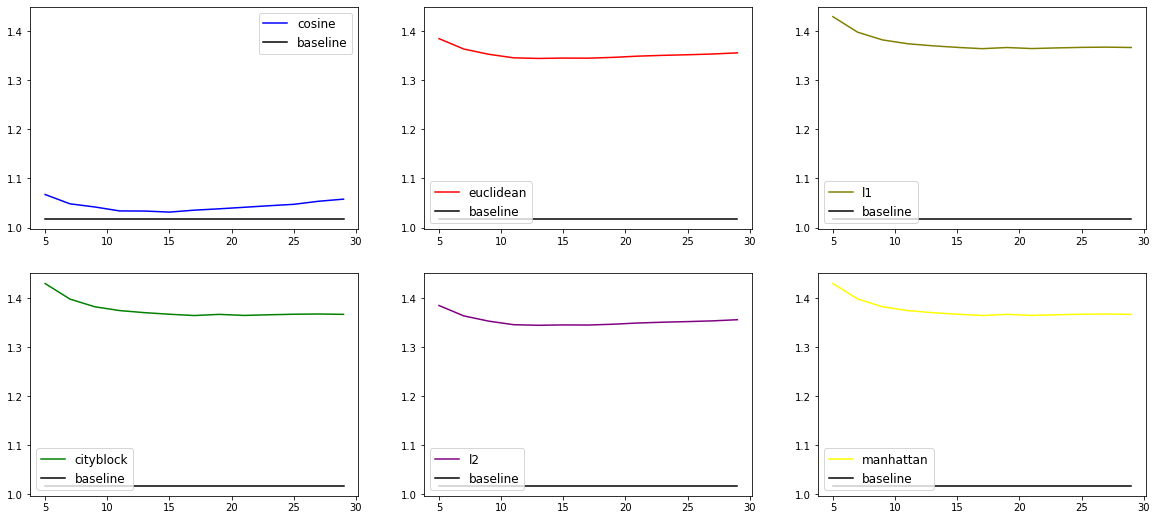

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

In [0]:
from sklearn.neighbors import NearestNeighbors
#auto', 'ball_tree', 'kd_tree', 'brute'
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
for user_id in users_testing["userId"]:
  neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
  #print(neighbors)
  predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 4. , 0. , ..., 5. , 3.5, 4.5],
       [0. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5. , 0. , 0. , ..., 3. , 0. , 4.5]])

In [0]:
predicted_ratings

array([[4.53333333, 4.8       , 4.36666667, ..., 3.93333333, 3.6       ,
        4.83333333],
       [3.06666667, 3.93333333, 2.5       , ..., 2.2       , 3.26666667,
        2.1       ],
       [4.33333333, 3.76666667, 4.03333333, ..., 3.26666667, 2.66666667,
        3.93333333],
       ...,
       [2.66666667, 4.56666667, 3.03333333, ..., 3.93333333, 3.3       ,
        4.76666667],
       [0.93333333, 1.23333333, 0.5       , ..., 3.2       , 2.13333333,
        4.8       ],
       [4.26666667, 3.4       , 2.86666667, ..., 4.2       , 2.93333333,
        4.76666667]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_users.append(np.average(r_squared(predicted_ratings,true_ratings)))

0.06737499895860487


In [0]:
squared_error = 0.0
n = 0
for user_id in users_testing["userId"]:
    nonzero_ratings = []
    for movie_id in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
            nonzero_ratings.append(movie_id)

    squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                             predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

1.0314102231891822

In [0]:
RMSES.append(rmse)

In [0]:
ratings = pandasDf
movies =pd.DataFrame(ratings["movieId"].unique())
movies.columns=["movieId"]


In [0]:
movies_training = movies.sample(frac=0.7)
movies_testing = movies.drop(movies_training.index)

In [0]:
ratings_training = pd.merge(ratings, movies_training, on=["movieId"])
ratings_testing = pd.merge(ratings, movies_testing, on=["movieId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(columns='userId', index='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

userId,156,741,768,775,903,982,1849,2261,2397,3284,3289,3318,3397,3664,3797,3858,3907,4222,4276,4358,4450,4507,4967,5843,6099,6373,6636,6719,7201,7699,7828,8405,8647,8805,8963,9034,9087,9544,9545,9562,...,129540,129583,130191,130459,130477,130622,130767,130987,131275,131347,131651,131894,131904,131961,133133,133372,133811,134401,134497,134567,134637,134690,134773,135033,135090,135155,135425,135795,136054,136268,136599,136875,137037,137202,137277,137343,137686,137885,138208,138325
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,0.0,4.5,4.0,3.0,4.5,3.0,4.0,5.0,5.0,4.5,3.5,5.0,0.0,4.0,4.0,5.0,0.0,5.0,3.0,4.0,4.0,5.0,4.0,2.5,4.0,4.0,4.5,5.0,2.5,5.0,3.0,3.0,2.5,0.0,5.0,3.0,3.0,5.0,...,5.0,4.5,5.0,0.0,3.0,3.0,4.5,4.0,5.0,5.0,2.0,5.0,3.0,4.0,2.5,5.0,5.0,0.0,5.0,4.0,3.0,4.5,5.0,0.0,2.5,5.0,3.0,3.5,3.5,4.0,4.0,4.0,4.0,4.5,4.0,4.0,5.0,5.0,3.0,5.0
3,2.0,3.0,0.0,3.5,2.0,2.0,2.5,2.5,4.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0,1.0,0.0,0.0,2.5,3.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,2.5,4.0,0.0,0.0,0.0,4.0,2.0,4.0,3.0,...,2.0,3.5,4.5,3.0,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,1.0,0.0,2.0,3.5,0.0,0.0,4.5,0.0,0.0,3.0,2.0,2.0,0.0,0.0,1.5,3.0,2.0,0.0,0.0,2.0,3.5,3.0,3.5,3.0,4.0,2.0,0.0
6,4.0,3.5,4.0,3.5,4.0,3.5,0.0,3.5,4.0,0.0,0.0,3.0,0.0,2.5,4.0,3.0,4.0,0.0,1.5,5.0,0.0,4.0,0.0,3.5,4.5,3.0,4.0,5.0,2.0,4.5,3.0,4.0,2.0,3.0,3.5,2.0,3.0,4.0,4.0,4.0,...,5.0,0.0,3.5,3.5,5.0,5.0,4.0,3.0,4.0,4.5,3.0,0.0,3.5,4.5,4.0,3.0,5.0,3.5,0.0,3.5,2.0,1.5,3.0,4.0,3.5,4.0,3.5,4.0,4.0,5.0,3.5,4.0,5.0,3.0,4.0,0.0,4.0,5.0,3.0,4.5
7,4.0,4.5,0.0,3.0,3.0,2.0,4.0,1.5,3.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,1.5,2.5,3.0,2.5,3.0,0.0,0.0,2.0,2.0,3.0,...,0.0,0.0,3.5,3.5,0.0,2.5,0.0,4.5,0.0,3.5,0.0,0.0,0.0,0.0,1.5,2.5,5.0,0.0,0.0,3.5,0.0,0.0,2.0,1.0,0.5,0.0,0.0,1.5,3.0,3.0,3.5,0.0,2.0,3.0,3.0,0.0,3.0,0.0,3.0,0.0
10,4.0,4.0,4.0,4.5,1.0,3.0,4.0,3.0,4.0,3.0,2.0,3.0,0.0,4.0,0.0,1.5,4.0,3.0,2.0,5.0,0.0,3.0,4.0,4.0,2.0,3.0,0.0,0.0,3.0,4.0,3.0,2.5,4.0,3.0,3.0,0.0,3.0,2.0,0.0,4.5,...,3.0,3.5,4.0,3.0,4.0,1.5,0.0,2.5,4.0,4.0,0.0,0.0,3.5,3.0,3.5,0.0,5.0,1.0,3.0,3.5,2.5,0.0,3.0,0.0,2.5,4.0,3.0,3.0,3.0,3.0,3.5,3.0,4.0,4.0,3.0,2.0,4.0,3.0,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.0,3.5,4.5,0.0,0.0,3.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,2.5,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,3.0,3.0,2.0,3.5,3.5,4.0,4.5,0.0,5.0,3.0,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,3.0,0.0,0.0,3.5,3.0,0.0,0.0,3.0,0.0
87232,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,3.0,2.5,3.5,4.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,4.0,3.0,3.0,4.0,5.0,4.0,0.0,0.0,3.5,0.0,0.0,0.0,4.5,0.0,4.5,0.0,0.0,3.5,3.5,0.0,0.0,0.0,0.0,0.0,3.5,4.0,0.0,0.0,0.0,4.0,3.5,4.0,0.0,0.0,3.5,0.0
88125,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,3.0,0.0,3.5,4.0,0.0,0.0,0.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,4.5,0.0,0.0,1.5,3.5,2.5,3.5,4.5,4.5,0.0,0.0,3.5,0.0,0.0,0.0,4.5,0.0,4.5,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,4.0,3.0,4.0,4.5,0.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for movieId in movies_testing["movieId"]:
    neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
    predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for movieId in movies_testing["movieId"]:
      nonzero_ratings = []
      for userId in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
              nonzero_ratings.append(userId)

      squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                              predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


29 cosine 0.9262212694799511


In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

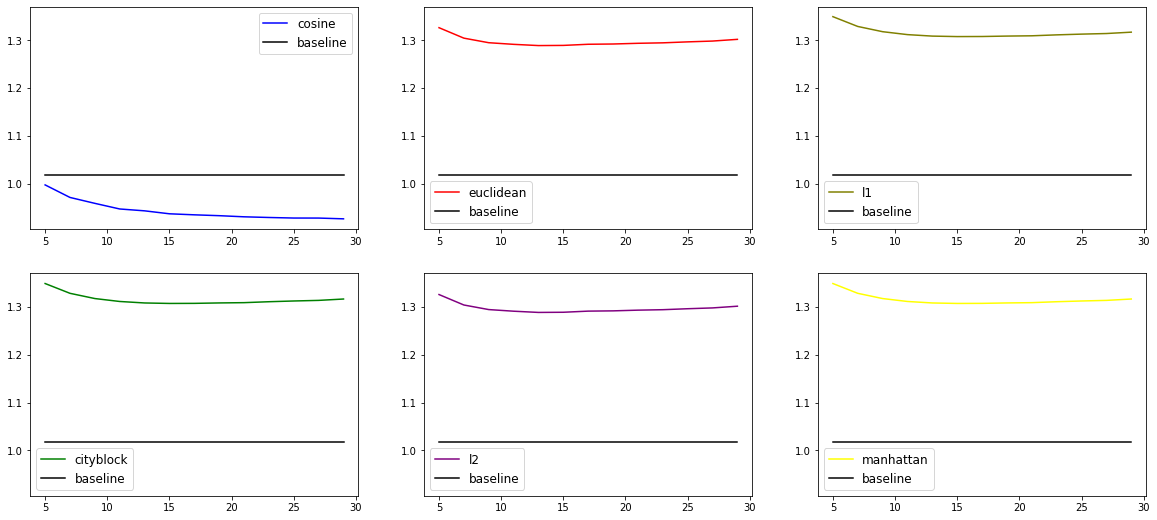

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

In [0]:
from sklearn.neighbors import NearestNeighbors
#auto', 'ball_tree', 'kd_tree', 'brute'
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=29, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies_testing["movieId"]:
  neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
  predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 3. , ..., 0. , 0. , 0. ]])

In [0]:
predicted_ratings

array([[4.55172414, 4.44827586, 4.22413793, ..., 3.79310345, 3.51724138,
        4.74137931],
       [3.62068966, 3.67241379, 2.4137931 , ..., 2.51724138, 3.05172414,
        2.12068966],
       [4.37931034, 3.70689655, 3.89655172, ..., 3.03448276, 2.82758621,
        3.87931034],
       ...,
       [0.        , 0.        , 2.36206897, ..., 0.        , 2.18965517,
        2.9137931 ],
       [0.        , 0.        , 2.89655172, ..., 0.        , 2.10344828,
        2.29310345],
       [0.        , 0.        , 2.53448276, ..., 0.        , 2.17241379,
        3.05172414]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_items.append(np.average(r_squared(predicted_ratings,true_ratings)))

-0.0451591127139207


In [0]:
squared_error = 0.0
n = 0
for movieId in movies_testing["movieId"]:
    nonzero_ratings = []
    for userId in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
            nonzero_ratings.append(userId)

    squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                             predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

0.9262212694799511

In [0]:
RMSES1.append(rmse)

In [0]:
matrix  = ratings.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
matrix_sparse = csr_matrix(matrix.values)


In [0]:
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=29, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(matrix_sparse,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies["movieId"]:
  neighbors = neighbor_indices[list(movies["movieId"]).index(movieId)]
  predicted_ratings[list(movies["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))
for movieId in movies["movieId"]:
  true_ratings[list(movies["movieId"]).index(movieId), :] = matrix.values[list(movies["movieId"]).index(movieId)]


In [0]:
predicted_ratings

array([[4.31034483, 4.22413793, 3.62068966, ..., 3.03448276, 3.43103448,
        4.63793103],
       [4.62068966, 3.43103448, 3.34482759, ..., 3.20689655, 3.10344828,
        3.56896552],
       [3.72413793, 3.44827586, 2.75862069, ..., 3.06896552, 2.63793103,
        2.27586207],
       ...,
       [0.        , 0.17241379, 2.62068966, ..., 0.        , 3.20689655,
        3.13793103],
       [0.        , 0.        , 2.89655172, ..., 0.        , 3.        ,
        3.01724138],
       [0.        , 0.        , 2.53448276, ..., 0.        , 3.18965517,
        3.31034483]])

In [0]:
recommendations = pd.DataFrame(data=predicted_ratings)

In [0]:
recommendations1 = recommendations.transpose()

In [0]:
recommendations1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,4.310345,4.620690,3.724138,3.655172,4.344828,3.931034,3.551724,4.413793,4.482759,3.224138,2.793103,4.137931,3.896552,2.896552,3.637931,4.172414,3.965517,4.482759,4.000000,4.172414,4.206897,1.655172,2.172414,4.310345,4.482759,4.241379,4.189655,4.068966,2.672414,3.120690,3.793103,3.172414,4.344828,3.068966,4.344828,2.862069,3.310345,3.793103,4.413793,2.224138,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.224138,3.431034,3.448276,3.086207,4.362069,3.448276,1.017241,3.931034,3.689655,1.620690,3.517241,4.465517,4.068966,3.913793,2.879310,1.741379,4.189655,3.775862,1.913793,2.327586,4.258621,2.344828,3.327586,3.396552,4.241379,3.586207,4.155172,3.551724,4.379310,2.431034,3.637931,1.758621,4.275862,2.620690,4.327586,3.982759,4.155172,3.206897,3.431034,0.689655,...,0.551724,1.034483,0.879310,0.724138,0.655172,0.500000,0.551724,0.534483,0.655172,0.500000,0.862069,1.017241,0.500000,0.706897,0.724138,0.086207,0.862069,0.500000,0.568966,0.706897,0.655172,0.500000,0.206897,0.155172,0.086207,0.224138,0.655172,0.000000,0.551724,0.500000,0.206897,0.551724,0.344828,0.000000,0.000000,0.051724,0.051724,0.172414,0.000000,0.000000
2,3.620690,3.344828,2.758621,2.258621,4.155172,1.827586,3.068966,3.827586,3.155172,2.862069,2.068966,4.224138,1.706897,3.465517,3.224138,2.844828,3.741379,3.637931,3.068966,2.827586,3.327586,0.120690,2.689655,2.862069,4.051724,3.413793,2.965517,3.362069,0.913793,3.482759,2.586207,0.586207,4.086207,1.793103,4.034483,1.551724,1.189655,2.224138,2.534483,1.862069,...,2.655172,2.275862,2.155172,3.086207,2.431034,2.534483,2.517241,2.672414,2.672414,2.637931,2.931034,2.379310,2.534483,2.431034,2.034483,2.672414,2.810345,3.051724,2.017241,2.551724,3.051724,2.775862,2.568966,2.913793,2.827586,2.431034,2.655172,2.758621,2.137931,2.413793,2.672414,2.293103,2.413793,2.637931,2.913793,2.655172,2.793103,2.620690,2.896552,2.534483
3,4.310345,4.000000,3.517241,3.293103,4.379310,3.465517,1.862069,4.241379,3.793103,3.431034,4.465517,4.396552,3.827586,4.034483,3.500000,2.689655,4.189655,3.827586,2.172414,3.551724,4.344828,2.586207,4.327586,3.620690,4.431034,4.206897,4.137931,4.172414,4.379310,3.620690,4.293103,2.706897,4.413793,3.206897,4.465517,3.913793,3.965517,3.517241,3.655172,2.706897,...,0.000000,0.172414,0.172414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172414,0.000000,0.000000,0.172414,0.258621,0.000000,0.155172,0.172414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103448,0.000000,0.000000,0.000000,0.000000,0.103448,0.000000,0.000000,0.000000,0.000000
4,3.793103,3.793103,3.551724,3.413793,4.172414,3.620690,2.448276,3.206897,3.896552,3.068966,3.793103,4.413793,3.724138,3.482759,3.310345,2.724138,4.241379,3.758621,2.724138,3.275862,4.172414,2.827586,3.241379,3.586207,3.931034,3.931034,4.172414,4.103448,3.344828,2.896552,4.310345,2.517241,4.137931,3.413793,4.344828,4.241379,3.310345,3.655172,3.620690,2.413793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
l = []
temp_list=[]
for i in recommendations1.index:
  for j in recommendations1.columns:
    temp= (movies["movieId"][j],recommendations1.loc[i][j])
    temp_list.append(temp)
  l.append(temp_list)
  temp_list=[]

In [0]:
finallist=[]
for list1 in l:
  finallist.append(sorted(list1, key=lambda x: x[1], reverse=True))

In [0]:
d={"userId":users["userId"], "recommendations":finallist}
rec_movies_1=pd.DataFrame(d)

In [0]:
from operator import itemgetter
from itertools import groupby
import pandas as pd
list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

In [0]:
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

In [0]:
l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

In [0]:
Coverage = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies = " + str(Coverage) )

Coverage of movies = 0.692


In [0]:
Coverage_Items.append(Coverage)

In [0]:
list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 
Coverage = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users = " + str(Coverage))

Coverage based on users = 0.9309153713298791


In [0]:
Coverage_users.append(Coverage)

#Sampling the Data -Ratings of the top 2000 movies from users that have rated more than 1500 movies and repaeting the things done previously

In [0]:
ratingsData = spark.read.load("/content/drive/My Drive/ml-20m/ratings.csv",format="csv",header=True,inferSchema=True)
#ratingsData.show(5)

ratingsDataByCount = ratingsData.groupby('movieId').count()
#ratingsDataByCount.show()

ratingsDataByCount = ratingsDataByCount.sort('count', ascending=False)

#selecting the top 1000 most popular movie 
ratingsDataByCount = ratingsDataByCount.limit(2000)

#Register the DataFrame as a SQL temporary view
ratingsDataByCount.createOrReplaceTempView("ratingsDataByCount")
ratingsData.createOrReplaceTempView("ratingsData")

ratingsData_1 = spark.sql("SELECT ratingsData.movieId, ratingsData.userId, ratingsData.rating FROM ratingsData, ratingsDataByCount where ratingsData.movieId = ratingsDataByCount.movieId")

ratingsDataByUserCount = ratingsData.groupby('userId').count()
ratingsDataByUserCount = ratingsDataByUserCount.sort('count', ascending=False)

#Register the DataFrame as a SQL temporary view
ratingsDataByUserCount.createOrReplaceTempView("ratingsDataByUserCount")
ratingsData_1.createOrReplaceTempView("ratingsData_1")

ratingsData_2 = spark.sql("SELECT ratingsData_1.movieId, ratingsData_1.userId, ratingsData_1.rating FROM ratingsDataByUserCount, ratingsData_1 WHERE ratingsData_1.userId = ratingsDataByUserCount.userId and ratingsDataByUserCount.count > 1500")

pandasDf = ratingsData_2.toPandas()

In [0]:
ratings = pandasDf
users =pd.DataFrame(ratings["userId"].unique())
users.columns=["userId"]

In [0]:
users_training = users.sample(frac=0.7)
users_testing = users.drop(users_training.index)

In [0]:
ratings_training = pd.merge(ratings, users_training, on=["userId"])
ratings_testing = pd.merge(ratings, users_testing, on=["userId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(index='userId', columns='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

movieId,1,2,3,4,5,6,7,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,31,32,34,36,39,41,42,43,44,45,46,47,48,50,...,77561,78499,79091,79132,79702,80463,80489,81562,81591,81834,81845,81847,81932,82459,84152,85414,86332,86882,87232,88125,88129,88140,88744,89492,89745,91500,91529,91542,91658,92259,94864,94959,96079,96610,97304,97921,98809,99114,104841,109374
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
156,5.0,5.0,2.0,3.0,3.0,4.0,4.0,3.0,4.0,5.0,3.0,0.0,4.0,4.0,4.0,3.0,0.0,3.0,4.0,4.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,5.0,3.0,3.5,0.0,0.0,3.0,4.0,0.0,2.0,0.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
768,0.0,3.0,0.0,0.0,2.0,4.0,0.0,3.0,4.0,0.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,4.0,...,3.5,0.0,0.0,4.0,0.0,0.0,3.5,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,3.5,3.5,0.0,2.0,3.0,0.0,3.0,4.0,4.0,3.5,4.0,0.0,4.0,0.0,4.0,3.5,0.0,0.0,4.0,3.0,3.5,4.0
903,4.0,4.0,2.0,2.0,3.0,4.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,3.0,3.0,2.0,1.0,2.0,4.0,2.0,2.0,2.0,4.0,3.0,0.0,4.0,0.0,4.0,4.0,2.0,3.0,2.0,4.0,3.0,2.0,4.0,0.0,4.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1849,4.5,3.0,2.5,0.0,3.0,0.0,4.0,0.0,4.0,4.0,2.5,0.0,3.0,0.0,4.0,0.0,2.0,0.0,3.0,3.5,0.0,3.0,0.0,4.0,0.0,0.0,3.0,3.5,3.5,0.0,3.5,0.0,0.0,0.0,0.0,3.5,3.0,4.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2261,3.0,3.5,2.5,0.0,1.0,3.5,1.5,0.0,3.0,4.5,0.0,3.0,2.5,3.0,0.0,2.0,1.5,2.5,3.0,3.5,0.0,3.0,3.0,0.0,0.0,0.0,2.5,3.5,4.0,2.5,3.0,0.0,1.0,2.5,0.0,2.5,0.0,4.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136599,4.0,2.0,0.0,0.0,0.0,3.5,3.5,0.0,3.5,3.5,0.0,3.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,4.0,4.5,4.0,3.0,3.5,0.0,3.5,0.0,3.5,0.0,4.5,0.0,4.5,...,0.0,4.5,0.0,4.5,3.5,3.5,0.0,0.0,3.5,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.0,3.5,0.0,3.5,4.0,0.0,0.0,4.0,0.0,0.0,4.0,3.5,0.0,4.0,0.0,0.0,0.0,4.0,4.0,4.5,4.5
136875,4.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,4.5,0.0,4.0,2.5,3.5,4.0,3.5,3.0,0.0,0.0,0.0,0.0,4.5,0.0,4.5,1.0,4.0,2.0,0.0,0.0,0.0,2.5,3.0,0.0,5.0,0.0,5.0,...,0.0,0.0,3.0,4.5,4.0,4.0,4.0,2.5,4.5,4.5,4.0,3.0,5.0,4.5,3.5,3.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137037,4.0,3.0,2.0,0.0,3.0,5.0,2.0,1.0,4.0,3.0,1.0,4.0,1.0,4.0,3.0,4.0,3.0,2.0,3.0,3.0,1.0,2.0,4.0,0.0,0.0,0.0,2.0,3.0,2.5,4.0,2.0,4.0,1.0,0.0,1.0,4.0,0.0,5.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for user_id in users_testing["userId"]:
    neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
    predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for user_id in users_testing["userId"]:
      nonzero_ratings = []
      for movie_id in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
              nonzero_ratings.append(movie_id)

      squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                              predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


9 cosine 1.1091420363901572


In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

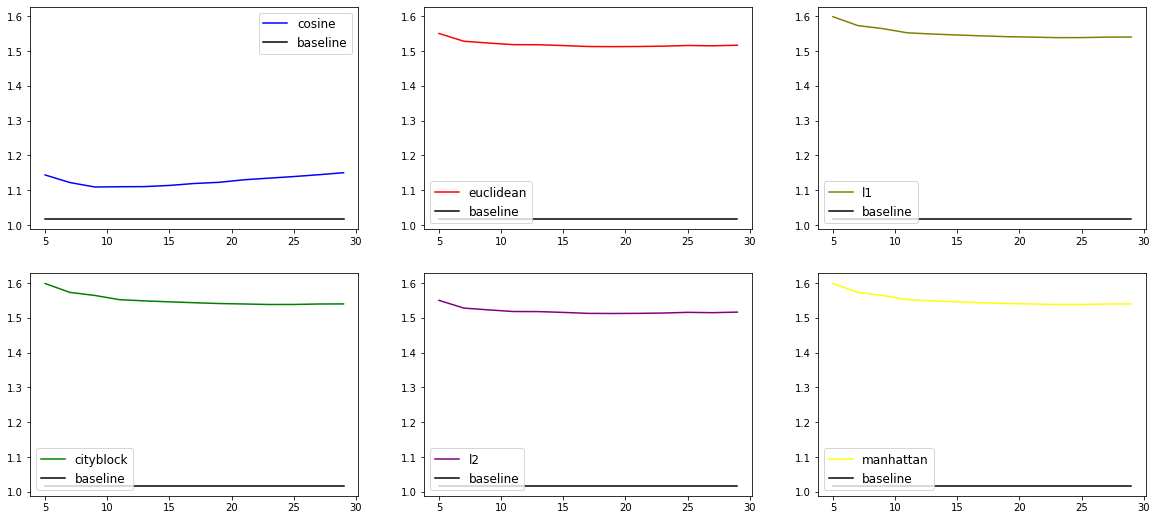

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

In [0]:
from sklearn.neighbors import NearestNeighbors
#auto', 'ball_tree', 'kd_tree', 'brute'
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=9, p=2, radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))

In [0]:
for user_id in users_testing["userId"]:
  neighbors = neighbor_indices[list(users_testing["userId"]).index(user_id)]
  #print(neighbors)
  predicted_ratings[list(users_testing["userId"]).index(user_id), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(users_testing),movie_user_mat_train.shape[1]))
for user_id in users_testing["userId"]:
  true_ratings[list(users_testing["userId"]).index(user_id), :] = movie_user_mat_test.values[list(users_testing["userId"]).index(user_id)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 4. , 0. , ..., 5. , 3.5, 4.5],
       [0. , 0. , 0. , ..., 0. , 0. , 5. ],
       [5. , 0. , 0. , ..., 3. , 0. , 4.5]])

In [0]:
predicted_ratings

array([[4.22222222, 5.        , 4.33333333, ..., 4.11111111, 3.77777778,
        4.77777778],
       [2.55555556, 4.16666667, 2.33333333, ..., 2.        , 3.33333333,
        1.83333333],
       [4.44444444, 3.88888889, 4.11111111, ..., 3.        , 2.77777778,
        3.5       ],
       ...,
       [3.11111111, 4.94444444, 3.44444444, ..., 4.44444444, 3.66666667,
        4.83333333],
       [0.33333333, 0.94444444, 0.        , ..., 3.33333333, 2.22222222,
        4.94444444],
       [4.33333333, 3.55555556, 2.44444444, ..., 4.11111111, 2.55555556,
        4.83333333]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_users.append(np.average(r_squared(predicted_ratings,true_ratings)))

0.10126810916297041


In [0]:
squared_error = 0.0
n = 0
for user_id in users_testing["userId"]:
    nonzero_ratings = []
    for movie_id in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(users_testing["userId"]).index(user_id), movie_id] > 0.0:
            nonzero_ratings.append(movie_id)

    squared_error += np.sum((true_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings] -
                             predicted_ratings[list(users_testing["userId"]).index(user_id), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

1.1091420363901572

In [0]:
RMSES.append(rmse)

In [0]:
ratings = pandasDf
movies =pd.DataFrame(ratings["movieId"].unique())
movies.columns=["movieId"]


In [0]:
movies_training = movies.sample(frac=0.7)
movies_testing = movies.drop(movies_training.index)

In [0]:
ratings_training = pd.merge(ratings, movies_training, on=["movieId"])
ratings_testing = pd.merge(ratings, movies_testing, on=["movieId"])

In [0]:
movie_user_mat_train = ratings_training.pivot(columns='userId', index='movieId', values='rating').fillna(0)
movie_user_mat_test = ratings_testing.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
movie_user_mat_train

userId,156,741,768,775,903,982,1849,2261,2397,3284,3289,3318,3397,3664,3797,3858,3907,4222,4276,4358,4450,4507,4967,5843,6099,6373,6636,6719,7201,7699,7828,8405,8647,8805,8963,9034,9087,9544,9545,9562,...,129540,129583,130191,130459,130477,130622,130767,130987,131275,131347,131651,131894,131904,131961,133133,133372,133811,134401,134497,134567,134637,134690,134773,135033,135090,135155,135425,135795,136054,136268,136599,136875,137037,137202,137277,137343,137686,137885,138208,138325
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,0.0,4.5,4.0,3.0,4.5,3.0,4.0,5.0,5.0,4.5,3.5,5.0,0.0,4.0,4.0,5.0,0.0,5.0,3.0,4.0,4.0,5.0,4.0,2.5,4.0,4.0,4.5,5.0,2.5,5.0,3.0,3.0,2.5,0.0,5.0,3.0,3.0,5.0,...,5.0,4.5,5.0,0.0,3.0,3.0,4.5,4.0,5.0,5.0,2.0,5.0,3.0,4.0,2.5,5.0,5.0,0.0,5.0,4.0,3.0,4.5,5.0,0.0,2.5,5.0,3.0,3.5,3.5,4.0,4.0,4.0,4.0,4.5,4.0,4.0,5.0,5.0,3.0,5.0
2,5.0,3.0,3.0,2.0,4.0,2.0,3.0,3.5,4.0,3.0,0.0,3.0,2.0,4.5,2.0,1.5,2.5,0.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0,2.5,0.0,4.0,1.0,2.0,2.5,3.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,4.0,...,3.0,3.5,3.5,3.5,0.5,3.0,0.0,3.0,3.5,2.5,0.0,5.0,3.0,2.0,2.5,3.0,5.0,2.5,4.0,4.0,0.0,2.0,0.0,0.0,2.5,0.0,0.0,4.0,0.0,2.0,2.0,3.0,3.0,2.5,2.5,2.5,3.0,3.0,2.0,3.0
3,2.0,3.0,0.0,3.5,2.0,2.0,2.5,2.5,4.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,3.5,0.0,1.0,0.0,0.0,2.5,3.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,2.5,4.0,0.0,0.0,0.0,4.0,2.0,4.0,3.0,...,2.0,3.5,4.5,3.0,0.0,0.0,0.0,4.0,0.0,3.5,0.0,0.0,0.0,1.0,0.0,2.0,3.5,0.0,0.0,4.5,0.0,0.0,3.0,2.0,2.0,0.0,0.0,1.5,3.0,2.0,0.0,0.0,2.0,3.5,3.0,3.5,3.0,4.0,2.0,0.0
4,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,0.0,0.0,0.0,0.0,...,0.0,0.0,3.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
5,3.0,4.0,2.0,1.0,3.0,2.5,3.0,1.0,4.0,0.0,2.0,2.5,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,2.0,3.0,0.0,2.5,0.0,0.0,3.5,0.0,0.5,2.5,1.5,0.0,1.0,0.0,0.0,3.5,0.0,0.0,0.0,...,3.0,0.0,3.0,0.0,0.0,0.0,0.0,2.5,4.0,2.5,0.0,0.0,0.0,1.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,1.5,0.0,0.0,1.0,2.5,0.0,0.0,0.0,3.0,0.0,3.0,3.5,0.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96079,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.5,0.0,5.0,...,0.0,4.0,0.0,3.5,4.0,2.5,0.0,3.0,3.5,5.0,0.0,0.0,3.5,0.0,0.0,0.0,4.5,0.0,4.0,3.5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,3.5,4.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0
96610,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,3.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,...,0.0,3.5,0.0,2.5,4.5,0.0,0.0,4.5,5.0,4.0,0.0,0.0,3.5,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,3.5,3.5,0.0,3.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0,0.0,4.5
97304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.5,2.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,5.0,4.5,0.0,0.0,4.0,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0


In [0]:
from scipy.sparse import csr_matrix
movie_user_mat_sparse_train = csr_matrix(movie_user_mat_train.values)
movie_user_mat_sparse_test = csr_matrix(movie_user_mat_test.values)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
import itertools
from math import sqrt
import sys
from operator import add
ks = range(5,31,2)
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
bestValidationRmse = float("inf")
bestk  = 5
bestmetric = "cosine"
rmses=[]
for k,metric in itertools.product(ks,metrics):
  model_knn = NearestNeighbors(metric= metric, algorithm='brute', n_neighbors=k, n_jobs=-1)
  model_knn.fit(movie_user_mat_sparse_train)  
  neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=k,return_distance=False)
  for movieId in movies_testing["movieId"]:
    neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
    predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)
  squared_error = 0.0
  n = 0
  for movieId in movies_testing["movieId"]:
      nonzero_ratings = []
      for userId in range(movie_user_mat_train.shape[1]):
          if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
              nonzero_ratings.append(userId)

      squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                              predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
      n += len(nonzero_ratings)

  rmse = np.sqrt(squared_error / n)
  rmses.append(rmse)
  if (rmse < bestValidationRmse):
    bestk  = k
    bestmetric = metric
    bestValidationRmse = rmse
print (bestk, bestmetric, bestValidationRmse) 


29 cosine 0.9301968906634104


In [0]:
#['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

cityblock_rmse=[]
cosine_rmse=[]
euclidean_rmse=[]
l1_rmse=[]
l2_rmse=[]
manhattan_rmse=[]

In [0]:
for i in range(0,len(rmses),6):
  cityblock_rmse.append(rmses[i])
  cosine_rmse.append(rmses[i+1])
  euclidean_rmse.append(rmses[i+2])
  l1_rmse.append(rmses[i+3])
  l2_rmse.append(rmses[i+4])
  manhattan_rmse.append(rmses[i+5])

In [0]:
index = []
baseline = []
baseline_1 = 1.0176954407887222

for i in range(5,31,2):
  index.append(i)
  baseline.append(baseline_1)

In [0]:
d = {"No_of_neighbours" : index,"cosine" : cosine_rmse, "euclidean" : euclidean_rmse, "l1" : l1_rmse, "cityblock" : cityblock_rmse, "l2" : l2_rmse, "manhattan" : manhattan_rmse, 'baseline' : baseline}
df = pd.DataFrame(d)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

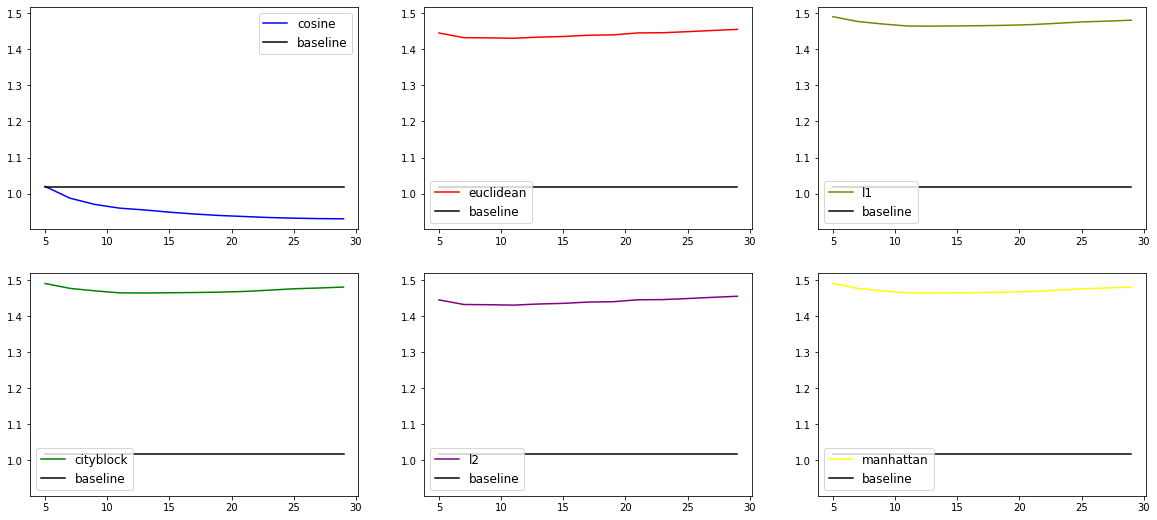

In [0]:
fig = plt.figure(figsize=(20, 9))
#fig.subplots_adjust(hspace=0.8, wspace=0.7)
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2, sharey=ax1)
ax3 = fig.add_subplot(2, 3, 3, sharey=ax1)
ax4 = fig.add_subplot(2, 3, 4, sharey=ax1)
ax5 = fig.add_subplot(2, 3, 5, sharey=ax1)
ax6 = fig.add_subplot(2, 3, 6, sharey=ax1)

ax1.plot("No_of_neighbours", "cosine",data = df, color = 'blue', label = 'cosine') 
ax1.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')
#ax1.yticks(np.arange(0.8, 1.5, step=0.2))

ax2.plot("No_of_neighbours", "euclidean",data = df, color = 'red', label = 'euclidean') 
ax2.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax3.plot("No_of_neighbours", "l1",data = df, color = 'olive', label = 'l1') 
ax3.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax4.plot("No_of_neighbours", "cityblock",data = df, color = 'green', label = 'cityblock') 
ax4.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax5.plot("No_of_neighbours", "l2",data = df, color = 'purple', label = 'l2') 
ax5.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')

ax6.plot("No_of_neighbours", "manhattan",data = df, color = 'yellow', label = 'manhattan') 
ax6.plot("No_of_neighbours", "baseline", data = df, color='black', label = 'baseline')


ax1.legend(loc=0, fontsize = 'large')
ax2.legend(loc=3, fontsize = 'large')
ax3.legend(loc=3, fontsize = 'large')
ax4.legend(loc=3, fontsize = 'large')
ax5.legend(loc=3, fontsize = 'large')
ax6.legend(loc=3, fontsize = 'large')

In [0]:
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=29, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(movie_user_mat_sparse_test,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies_testing["movieId"]:
  neighbors = neighbor_indices[list(movies_testing["movieId"]).index(movieId)]
  predicted_ratings[list(movies_testing["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies_testing),movie_user_mat_train.shape[1]))
for movieId in movies_testing["movieId"]:
  true_ratings[list(movies_testing["movieId"]).index(movieId), :] = movie_user_mat_test.values[list(movies_testing["movieId"]).index(movieId)]


In [0]:
true_ratings

array([[4. , 3.5, 4. , ..., 5. , 3. , 4.5],
       [4. , 4.5, 0. , ..., 0. , 3. , 0. ],
       [4. , 4. , 4. , ..., 3. , 2. , 3.5],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 3. , ..., 0. , 0. , 0. ]])

In [0]:
predicted_ratings

array([[4.55172414, 4.44827586, 4.22413793, ..., 3.79310345, 3.51724138,
        4.74137931],
       [3.62068966, 3.67241379, 2.4137931 , ..., 2.51724138, 3.05172414,
        2.12068966],
       [4.37931034, 3.70689655, 3.89655172, ..., 3.03448276, 2.82758621,
        3.87931034],
       ...,
       [0.        , 0.        , 2.36206897, ..., 0.        , 2.18965517,
        2.9137931 ],
       [0.        , 0.        , 2.89655172, ..., 0.        , 2.10344828,
        2.29310345],
       [0.        , 0.        , 2.53448276, ..., 0.        , 2.17241379,
        3.05172414]])

In [0]:
print(np.average(r_squared(predicted_ratings,true_ratings)))
R2_items.append(np.average(r_squared(predicted_ratings,true_ratings)))

-0.0451591127139207


In [0]:
squared_error = 0.0
n = 0
for movieId in movies_testing["movieId"]:
    nonzero_ratings = []
    for userId in range(movie_user_mat_train.shape[1]):
        if true_ratings[list(movies_testing["movieId"]).index(movieId), userId] > 0.0:
            nonzero_ratings.append(userId)

    squared_error += np.sum((true_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings] -
                             predicted_ratings[list(movies_testing["movieId"]).index(movieId), nonzero_ratings]) ** 2)
    n += len(nonzero_ratings)

rmse = np.sqrt(squared_error / n)

In [0]:
rmse

0.9301968906634104

In [0]:
RMSES1.append(rmse)

In [0]:
matrix  = ratings.pivot(columns='userId', index='movieId', values='rating').fillna(0)

In [0]:
matrix_sparse = csr_matrix(matrix.values)


In [0]:
model_knn = NearestNeighbors(metric=bestmetric, algorithm='brute', n_neighbors=bestk, n_jobs=-1)
model_knn.fit(movie_user_mat_sparse_train)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=29, p=2,
                 radius=1.0)

In [0]:
neighbor_indices = model_knn.kneighbors(matrix_sparse,n_neighbors=bestk,return_distance=False)

In [0]:
predicted_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))

In [0]:
for movieId in movies["movieId"]:
  neighbors = neighbor_indices[list(movies["movieId"]).index(movieId)]
  predicted_ratings[list(movies["movieId"]).index(movieId), :] = np.average(movie_user_mat_train.values[neighbors, :], axis=0)

In [0]:
true_ratings = np.zeros((len(movies["movieId"]),movie_user_mat_train.shape[1]))
for movieId in movies["movieId"]:
  true_ratings[list(movies["movieId"]).index(movieId), :] = matrix.values[list(movies["movieId"]).index(movieId)]


In [0]:
predicted_ratings

array([[4.10344828, 4.32758621, 3.72413793, ..., 3.13793103, 3.39655172,
        4.60344828],
       [4.24137931, 3.60344828, 3.53448276, ..., 3.        , 3.03448276,
        3.79310345],
       [3.51724138, 3.18965517, 2.9137931 , ..., 2.82758621, 2.67241379,
        2.25862069],
       ...,
       [0.        , 0.        , 2.53448276, ..., 0.        , 2.17241379,
        3.05172414],
       [0.        , 0.        , 2.32758621, ..., 0.        , 2.24137931,
        2.94827586],
       [0.        , 0.        , 2.34482759, ..., 0.        , 2.27586207,
        2.94827586]])

In [0]:
recommendations = pd.DataFrame(data=predicted_ratings)

In [0]:
recommendations1 = recommendations.transpose()

In [0]:
recommendations1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,4.103448,4.241379,3.517241,3.551724,3.241379,4.551724,3.620690,3.551724,4.379310,3.931034,2.603448,2.655172,3.965517,4.103448,3.827586,2.758621,3.603448,4.034483,3.793103,4.413793,3.827586,4.137931,4.206897,3.275862,2.206897,2.586207,3.862069,4.206897,4.206897,3.965517,4.103448,2.413793,2.827586,2.655172,3.017241,3.689655,3.344828,4.137931,2.862069,4.482759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4.327586,3.603448,3.189655,0.827586,2.706897,4.448276,3.672414,1.224138,3.706897,3.948276,1.051724,3.637931,2.637931,4.500000,4.534483,3.862069,2.896552,1.913793,4.620690,3.793103,1.568966,2.431034,4.379310,4.396552,2.862069,3.948276,3.827586,4.637931,3.879310,4.396552,3.896552,4.172414,2.896552,2.655172,2.344828,3.672414,1.500000,4.431034,2.810345,4.603448,...,0.137931,0.172414,0.000000,0.603448,0.000000,0.344828,0.172414,0.155172,0.500000,0.000000,0.344828,0.000000,0.000000,0.000000,0.155172,0.000000,0.000000,0.000000,0.000000,0.000000,0.172414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172414,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3.724138,3.534483,2.913793,0.827586,2.275862,4.224138,2.413793,2.810345,3.896552,3.206897,2.620690,1.844828,3.672414,4.120690,1.758621,3.637931,3.344828,2.827586,3.775862,3.758621,3.172414,3.103448,3.103448,0.965517,0.000000,3.068966,3.068966,4.120690,3.241379,2.844828,3.431034,1.086207,2.758621,0.000000,3.500000,2.310345,0.379310,4.224138,1.879310,4.206897,...,2.982759,2.482759,2.586207,2.603448,2.620690,1.775862,2.034483,1.862069,2.137931,2.706897,2.172414,2.603448,2.051724,2.258621,2.948276,2.689655,2.948276,2.034483,2.879310,2.724138,2.137931,3.086207,2.724138,2.206897,2.620690,2.620690,2.758621,3.034483,2.655172,1.948276,3.103448,2.120690,2.948276,2.620690,2.241379,2.362069,2.896552,2.534483,2.327586,2.344828
3,4.448276,4.051724,3.500000,2.241379,3.086207,4.482759,3.672414,1.793103,4.189655,4.051724,3.137931,4.517241,3.172414,4.465517,3.982759,4.086207,3.603448,2.396552,4.379310,3.844828,1.965517,3.620690,4.396552,3.586207,2.482759,4.379310,3.724138,4.586207,4.293103,4.258621,4.206897,4.362069,3.741379,3.241379,3.517241,4.275862,2.103448,4.413793,3.517241,4.448276,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.689655,3.620690,3.413793,2.551724,3.103448,4.068966,3.758621,2.482759,3.379310,3.655172,2.896552,3.413793,2.758621,4.206897,4.000000,3.344828,3.206897,2.827586,4.103448,3.689655,2.655172,3.000000,3.965517,3.172414,2.862069,3.379310,3.482759,3.758621,3.896552,4.034483,4.034483,3.655172,3.344828,3.586207,2.896552,3.931034,2.448276,3.965517,3.103448,4.137931,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
l = []
temp_list=[]
for i in recommendations1.index:
  for j in recommendations1.columns:
    temp= (movies["movieId"][j],recommendations1.loc[i][j])
    temp_list.append(temp)
  l.append(temp_list)
  temp_list=[]

In [0]:
finallist=[]
for list1 in l:
  finallist.append(sorted(list1, key=lambda x: x[1], reverse=True))

In [0]:
d={"userId":users["userId"], "recommendations":finallist}
rec_movies_1=pd.DataFrame(d)

In [0]:
from operator import itemgetter
from itertools import groupby
import pandas as pd
list1 = []
for i in range(len(pandasDf)):
  tup1 = (pandasDf['movieId'][i],pandasDf['userId'][i] )
  list1.append(tup1)

sortkeyfn = itemgetter(1)
list1.sort(key=sortkeyfn)

result = {}
for key,valuesiter in groupby(list1, key=sortkeyfn):
    result[key] = list(v[0] for v in valuesiter)

In [0]:
list6 = []
for key,values in result.items():
  list5 = []
  x = list(rec_movies_1[rec_movies_1["userId"]==key]["recommendations"])
  for s1,s2 in x[0]:
    if s1 in values:
      continue
    else:
      if len(list5) == 10:
        break
      else:
        list5.append((s1,s2))
  list6.append((key,list5))

In [0]:
l1= []
for i in list6:
  user = i[0]
  for j in i[1]:
    l1.append([user,j[0]])
recoms = pd.DataFrame(l1,columns = ['UserId', 'Movie_Recs'])

In [0]:
Coverage = (recoms.iloc[:,1].nunique())/(pandasDf.iloc[:,0].nunique())
print("Coverage of movies = " + str(Coverage) )

Coverage of movies = 0.5905


In [0]:
Coverage_Items.append(Coverage)

In [0]:
list_b = []
count = 0
for i in list6:
  user = i[0]
  count1 = 0
  for j in i[1]:
    if j[1] >= 3.5:
      count1+=1
  if(count1 == 10):
    list_b.append(user)
    count = count + 1 
Coverage = (count)/(pandasDf.iloc[:,1].nunique())
print("Coverage based on users = " + str(Coverage))

Coverage based on users = 0.9481865284974094


In [0]:
Coverage_users.append(Coverage)

#Plotting RMSEs for different Samples

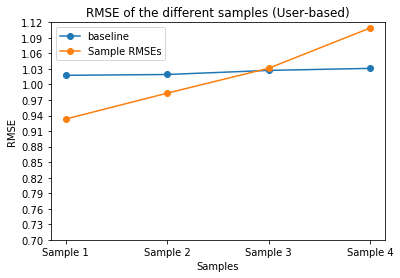

In [0]:
#from the baseline.ipynb we use the following values of our baseline model (evaluation metric = RMSE)
baseline_rmse = [1.0176954407887222, 1.0192983415161732, 1.0271992072986997, 1.031131960344556]
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

baseline_df = pd.DataFrame(baseline_rmse, sample_list)
plt.plot(baseline_df, marker='o', label = 'baseline')
plt.xlabel("Samples")
plt.ylabel("RMSE")
plt.title("RMSE of the different samples(User-Based)")


rmse_df = pd.DataFrame(RMSES, sample_list)
plt.plot(rmse_df, marker='o', label = 'Sample RMSEs')
plt.xlabel("Samples")
plt.ylabel("RMSE")
plt.yticks(np.arange(0.7,1.15,step=0.03))
plt.title("RMSE of the different samples (User-based)")
plt.legend(loc = 'best')

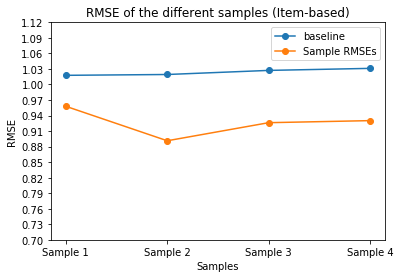

In [0]:
#from the baseline.ipynb we use the following values of our baseline model (evaluation metric = RMSE)
baseline_rmse = [1.0176954407887222, 1.0192983415161732, 1.0271992072986997, 1.031131960344556]
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

baseline_df = pd.DataFrame(baseline_rmse, sample_list)
plt.plot(baseline_df, marker='o', label = 'baseline')
plt.xlabel("Samples")
plt.ylabel("RMSE")
plt.title("RMSE of the different samples(Item-based)")


rmse_df = pd.DataFrame(RMSES1, sample_list)
plt.plot(rmse_df, marker='o', label = 'Sample RMSEs')
plt.xlabel("Samples")
plt.ylabel("RMSE")
plt.yticks(np.arange(0.7,1.15,step=0.03))
plt.title("RMSE of the different samples (Item-based)")
plt.legend(loc = 'best')

#Plotting Coverage for different samples 

Text(0.5, 1.0, 'Coverage of user for the different samples')

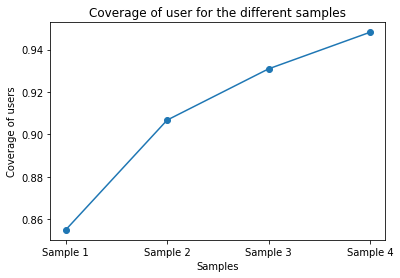

In [0]:
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

coverage_users_df = pd.DataFrame(Coverage_users, sample_list)

plt.plot(coverage_users_df, marker = 'o')
plt.xlabel("Samples")
plt.ylabel("Coverage of users")
plt.title("Coverage of user for the different samples")

Text(0.5, 1.0, 'Coverage of movies for the different samples')

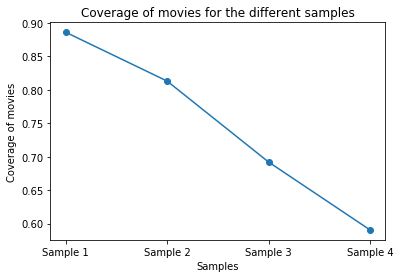

In [0]:
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

coverage_users_df = pd.DataFrame(Coverage_Items, sample_list)

plt.plot(coverage_users_df, marker = 'o')
plt.xlabel("Samples")
plt.ylabel("Coverage of movies")
plt.title("Coverage of movies for the different samples")

#Plotting R-squared for different samples

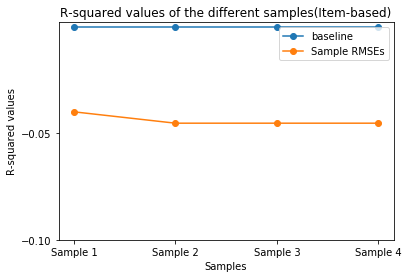

In [0]:
#from the baseline.ipynb we use the following values of our baseline model (evaluation metric = RMSE)
baseline_r2 = [0,0,0,0]
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

baseline_df = pd.DataFrame(baseline_r2, sample_list)
plt.plot(baseline_df, marker='o', label = 'baseline')
plt.xlabel("Samples")
plt.ylabel("R-squared values")
plt.title("R-squared values of the different samples(Item-based)")


rmse_df = pd.DataFrame(R2_items, sample_list)
plt.plot(rmse_df, marker='o', label = 'Sample RMSEs')
plt.xlabel("Samples")
plt.ylabel("R-squared values")
plt.yticks(np.arange(-0.1,0,step=0.05))
plt.title("R-squared values of the different samples(Item-based)")
plt.legend(loc = 'best')

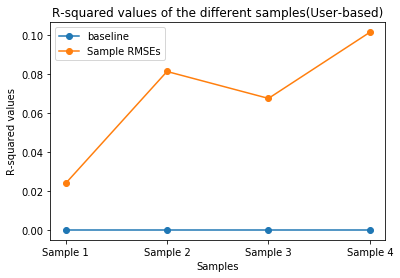

In [0]:
#from the baseline.ipynb we use the following values of our baseline model (evaluation metric = RMSE)
baseline_r2 = [0,0,0,0]
sample_list = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4']

baseline_df = pd.DataFrame(baseline_r2, sample_list)
plt.plot(baseline_df, marker='o', label = 'baseline')
plt.xlabel("Samples")
plt.ylabel("R-squared values")
plt.title("R-squared values of the different samples(User-based)")


rmse_df = pd.DataFrame(R2_users, sample_list)
plt.plot(rmse_df, marker='o', label = 'Sample RMSEs')
plt.xlabel("Samples")
plt.ylabel("R-squared values")
#plt.yticks(np.arange(-0.1,0,step=0.05))
plt.title("R-squared values of the different samples(User-based)")
plt.legend(loc = 'best')